In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import re
import warnings
import itertools
warnings.simplefilter(action='ignore', category=FutureWarning)
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Input, Model
from tensorflow.keras.initializers import RandomUniform, RandomNormal
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv1D, MaxPooling1D, Reshape, BatchNormalization
from tensorflow.keras.layers import AveragePooling1D, SeparableConv2D, Activation, concatenate, Conv2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import KLDivergence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.metrics import mean_absolute_error, explained_variance_score, mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.linear_model import RidgeCV
from tensorflow.keras.constraints import non_neg
warnings.resetwarnings()

# Model prototyping

The goal of this notebook is to get a feel for the performance of the two different types of models to be trained.
Specifically, comparison will be made between a naive baseline model, a ridge regression model, and a convolutional neural network model. Because this notebook is simply prototyping, a very small subset of the available data will be used; a single 
feature's time series for a single country, the United States. This single feature is all that will be available to the CNN and Ridge regression models; because eventually the feature data used in the regression is much larger than that used in the CNN training, this might be an unfair comparison.

The main issue for using a very small subset of data is that I believe it will affect the CNN more than the regression, because
the small number of samples influences how well the specific architecture will perform. Regardless I will press on and continue this testing. 

Both will use mean squared error as their loss function, unfortunately this means that I have to use RidgeCV, which means I need to provide my own folds in order to respect time ordering.

Much like how in regression we want to include multiple days of information for prediction,  it may also be benefitial to convolve multiple frames together for the CNN?

For the baseline testing, the ridge regression seems to benefit more from having more features, but in order to make the tests as simir

In [2]:
def country_slice(data, locations):
    if type(locations)==str:
        return data[data.location==locations]
    else:
        return data[data.location.isin(locations)]
    
def time_slice(data, start, end, indexer='time_index'):
    if start < 0 and end < 0:
        if start == -1:
            start = data.loc[:, indexer].max()
        else:
            start = data.loc[:, indexer].max()+start
        if end == -1:
            end = data.loc[:, indexer].max()
        else:
            end = data.loc[:, indexer].max()+end
    return data[(data.loc[:, indexer] >= start) & (data.loc[:, indexer] <= end)]

def per_country_plot(data, feature, legend=True):
    data.set_index(['time_index', 'location']).loc[:, feature].unstack().plot(legend=legend)
    return None

def per_time_plot(data, feature, legend=True):
    data.set_index(['location','time_index']).loc[:, feature].unstack().plot(legend=legend)
    return None

def country_groupby(df):
    return [df[df.location==country].index for country in df.location.unique()]

def country_search(df, country):
    return df[df.location==country].index

def column_search(df, name, return_style='loc', threshold='contains'):
    if threshold=='contains':
        func = df.columns.str.contains
    else:
        func = df.columns.str.match
        
    if return_style == 'loc':
        return df.columns[func(name)]
    elif return_style== 'iloc':
        return np.where(func(name))[0]
    else:
        return None


def concatenate_4d_into_3d(splits, train_test_only=False):
    
    if train_test_only:
        (X_train, y_train, X_test, y_test) = splits
        X_train = np.concatenate(X_train, axis=0)
        y_train = np.concatenate(y_train, axis=0)
        X_test = np.concatenate(X_test, axis=0)
        y_test = np.concatenate(y_test, axis=0)
        concat_splits = (X_train, y_train, X_test, y_test) 
    else:
        (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
        X_train = np.concatenate(X_train, axis=0)
        y_train = np.concatenate(y_train, axis=0)
        X_validate = np.concatenate(X_validate, axis=0)
        y_validate = np.concatenate(y_validate, axis=0)
        X_test = np.concatenate(X_test, axis=0)
        y_test = np.concatenate(y_test, axis=0)
        concat_splits = (X_train, y_train, X_validate, y_validate, X_test, y_test) 
    return concat_splits

def transpose_for_separable2d(splits, train_test_only=False):
    if train_test_only:
        (X_train, y_train, X_test, y_test) = splits
        X_train = np.transpose(X_train, axes=[0,2,1,3])
        X_test = np.transpose(X_test, axes=[0,2,1,3])
        transpose_split = (X_train, y_train, X_test, y_test) 
    else:
        (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
        X_train = np.transpose(X_train, axes=[0,2,1,3])
        X_validate = np.transpose(X_validate, axes=[0,2,1,3])
        X_test = np.transpose(X_test, axes=[0,2,1,3])
        transpose_split = (X_train, y_train, X_validate, y_validate, X_test, y_test) 
    return transpose_split

    
def true_predict_plot(y_true, y_naive, y_predict, title='', suptitle='', scale=None,s=None):
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20,5))
    if scale == 'log':
        ymax = np.max([np.log(1+y_true).max(), np.log(1+y_predict).max()])
        ax1.scatter(np.log(y_true+1), np.log(y_naive+1), s=s,alpha=0.7)
        ax1.plot([0, ymax], [0, ymax],color='r')
        ax2.scatter(np.log(y_true+1), np.log(y_predict+1), s=s,alpha=0.7)
        ax2.plot([0, ymax], [0, ymax],color='r')
    else:
        ymax = np.max([y_true.max(), y_predict.max()])
        ax1.scatter(y_true, y_naive, s=s)
        ax1.plot([0, ymax], [0, ymax],color='r')
        ax2.scatter(y_true, y_predict, s=s)
        ax2.plot([0, ymax], [0, ymax],color='r')
    ax1.set_xlabel('True value')
    ax1.set_ylabel('Predicted value')
    ax1.set_title('Naive model')

    ax2.set_xlabel('True value')
    ax2.set_ylabel('Predicted value')
    ax2.set_title(title)
    ax1.grid(True)
    ax2.grid(True)
    plt.suptitle(suptitle)
    plt.show()
    return None

def residual_plot(y_test, y_predict, title='', ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(y_test, y_test-y_predict.ravel(), s=5)
    ax.set_ylabel('Residual')
    ax.set_xlabel('True value')
    ax.grid(True)
    return None

def residual_diff_plots(y_true, y_naive, y_predict,n_days_into_future, n_countries, scale=None):
    fig, axes = plt.subplots(2, 2, figsize=(20,5), sharey=True)
    (ax1,ax2,ax3,ax4) = axes.flatten()
    xrange = range(len(y_true))
    if scale=='log':
        ax1.plot(xrange, np.log(y_true+1)
             -np.log(y_naive+1))
        ax2.plot(xrange, np.log(y_true+1)
                 -np.log(y_predict+1))
        residual_plot(np.log(y_true+1),np.log(y_naive+1), ax=ax3)
        residual_plot(np.log(y_true+1),np.log(y_predict+1), ax=ax4)
    else:
        ax1.plot(xrange, y_true-y_naive)
        ax2.plot(xrange, y_true-y_predict)
        residual_plot(y_true,y_naive, ax=ax3)
        residual_plot(y_true,y_predict, ax=ax4)
    fig.suptitle('{}-day-into-future predictions'.format(n_days_into_future))
    ax1.set_title('Country-wise differences')
    ax2.set_title('Country-wise differences')
    ax1.set_ylabel('True - Naive')
    ax2.set_ylabel('True - CNN')
    ax1.grid(True)
    ax2.grid(True)
    plt.show()
    return None



def create_Xy(model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries):
    for max_date_in_window in range(start_date, time_index.max() - n_days_into_future + 2):
        # Take all model_data with date proxy less than numerical value, leading_window_date_not_included
        frame_data = model_data[(time_index <= max_date_in_window-1) & 
                                (time_index >= max_date_in_window-frame_size)]
        #     print(frame_data.shape)
        # Reshape the array such that each element along axis=0 is a time series of all feature model_data of a specific country.
        reshaped_frame_data = frame_data.values.reshape(n_countries, frame_size, -1)
#         print(reshaped_frame_data.shape)
        #     print(reshaped_frame_data.shape)
        # Truncate / pad the windows along the "time" axis, axis=1. (pad_sequences takes in an iterable of iterables;
        # the first axis is always the default iteration axis. 
        # *********************** WARNING: pad_sequences converts to integers by default *********************
        resized_frame_data = pad_sequences(reshaped_frame_data, maxlen=frame_size, dtype=np.float64)
        frame_data_4D = resized_frame_data[np.newaxis, :, :, :]
        if max_date_in_window == start_date:
            print('Starting with frame ranging time_index values:', max_date_in_window-frame_size, max_date_in_window - 1)
            X = frame_data_4D.copy()
        else:
            X = np.concatenate((X, frame_data_4D),axis=0)
    print('Ending with frame ranging time_index values:', max_date_in_window-frame_size, max_date_in_window - 1)
    y = target_data.values.reshape(-1, time_index.nunique()).transpose()[-X.shape[0]:,:]
    return X, y

def split_Xy(X, y, frame_size, n_validation_frames, n_test_frames, train_test_only=False, model_type='cnn'):
    """ Split into training, validation and test data.
    """
    
    # the indices for the train-validate-test splits for when the predictors are put in a 2-d format.
    train_indices = list(range(n_countries*0, n_countries*(len(X)-(n_validation_frames+n_test_frames))))
    validate_indices = list(range(n_countries*(len(X)-(n_validation_frames+n_test_frames)), n_countries*(len(X)-n_test_frames)))
    test_indices = list(range(n_countries*(len(X)-n_test_frames), n_countries*len(X)))
    indices = (train_indices, validate_indices, test_indices)

    # Note that the last frame (date_range) that exists in X has already been determined by the choice of the number
    # of steps to predict in the future, this is only slicing the frames. 
    if train_test_only:
        X_train= X[:-n_test_frames,:,:,:]
        y_train =  y[:-n_test_frames,:]
        X_test = X[-n_test_frames:, :, :, :] 
        y_test = y[-n_test_frames:, :]
        splits =  (X_train, y_train, X_test, y_test)
    else:
        y_train =  y[:-(n_validation_frames+n_test_frames),:]
        y_validate = y[-(n_validation_frames+n_test_frames):-n_test_frames, :]
        X_train= X[:-(n_validation_frames+n_test_frames),:,:,:]
        y_train =  y[:-(n_validation_frames+n_test_frames),:]
        X_validate = X[-(n_validation_frames+n_test_frames):-n_test_frames, :, :, :]
        y_validate = y[-(n_validation_frames+n_test_frames):-n_test_frames, :]
        X_test = X[-n_test_frames:, :, :, :] 
        y_test = y[-n_test_frames:, :]
        splits =  (X_train, y_train, X_validate, y_validate,
                   X_test, y_test)

    return splits, indices


def flatten_Xy_splits(splits):
    (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
    X_train_flat =np.concatenate(X_train.reshape(X_train.shape[0], X_train.shape[1], -1), axis=0)
    X_validate_flat =np.concatenate(X_validate.reshape(X_validate.shape[0], X_validate.shape[1], -1), axis=0)
    X_test_flat =np.concatenate(X_test.reshape(X_test.shape[0], X_test.shape[1], -1), axis=0)
    y_train_flat = y_train.ravel()
    y_validate_flat = y_validate.ravel()
    y_test_flat = y_test.ravel()
    flat_splits = (X_train_flat , y_train_flat , X_validate_flat , y_validate_flat , X_test_flat , y_test_flat )
    return flat_splits

def model_analysis(y_true, y_naive, y_predict,n_countries, title='',suptitle=''):
    print('There were {} negative predictions'.format(len(y_predict[y_predict<0])))
    #     y_predict[y_predict<0]=0
    mse_train_naive = mean_squared_error(y_true.ravel(), y_naive.ravel())
    mse_predict = mean_squared_error(y_true.ravel(), y_predict)
    r2_train_naive = explained_variance_score(y_true.ravel(), y_naive.ravel())
    r2_predict = explained_variance_score(y_true.ravel(), y_predict)

    print('{}-step MSE [Naive, {}] = [{},{}]'.format(
    n_days_into_future,title, mse_train_naive, mse_predict))
    print('{}-step R^2 [Naive, {}] = [{},{}]'.format(
    n_days_into_future,title, r2_train_naive, r2_predict))

    true_predict_plot(y_true.ravel(), y_naive.ravel(), y_predict, title=title, suptitle=suptitle)
    residual_diff_plots(y_true.ravel(), y_naive.ravel(), y_predict , n_days_into_future, n_countries)
    return None


def normalize_Xy(splits, feature_range=(0., 1.0), normalization_method='minmax',
                        train_test_only=False, feature_indices=None):
    """ Split into training, validation and test data.
    Normalize with respect to some absolute max, just choose 2*absolute max of training set. 

    """
    
    min_, max_ = feature_range
    (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
    feature_minima = X_train[:,:,:,:].min((0,1,2))[np.newaxis,np.newaxis,np.newaxis,:]
    feature_maxima = 2*X_train[:,:,:,:].max((0,1,2))[np.newaxis,np.newaxis,np.newaxis,:]
    feature_denominator = feature_maxima-feature_minima
    # get the shape of each split's array, so that array arithmetic can be done. 
    train_tile_shape = np.array(np.array(X_train.shape)/np.array(feature_maxima.shape),int)
    validate_tile_shape = np.array(np.array(X_validate.shape)/np.array(feature_maxima.shape),int)
    test_tile_shape = np.array(np.array(X_test.shape)/np.array(feature_maxima.shape),int)

    # using X - X_min / (X_max-X_min). Form denominator
    train_denominator = np.tile(feature_denominator, train_tile_shape)
    validate_denominator = np.tile(feature_denominator, validate_tile_shape)
    test_denominator = np.tile(feature_denominator, test_tile_shape)
    
    # and then the minima.
    train_minima = np.tile(feature_minima,train_tile_shape)
    validate_minima = np.tile(feature_minima,validate_tile_shape)
    test_minima = np.tile(feature_minima,test_tile_shape)
    
    # factor of 1/max_ accounts for absolute maximum that is outside of the data (i.e. potential future values). 
    X_train_scaled = (max_-min_)*(X_train - train_minima)/train_denominator
    X_validate_scaled = (max_-min_)*(X_validate - validate_minima)/validate_denominator
    X_test_scaled = (max_-min_)*(X_test - test_minima)/test_denominator

    
    scaled_splits = (X_train_scaled, y_train, X_validate_scaled, y_validate, X_test_scaled, y_test) 
    scaling_arrays =  (feature_maxima, feature_minima, feature_denominator)

    return scaled_splits, scaling_arrays

In [3]:
# Import cleaned data produced by other notebook. 
global_data = pd.read_csv('cnn_data.csv',index_col=0)

For the prototype, see what kind of result we get with just the data on the United States, and only use the new_cases_per_million feature.

In [4]:
data = global_data[global_data.location=='United States'].reset_index(drop=True)
# not enough countries have new_recovered_weighted values.
data = data.drop(columns=['date'])
data = data.drop(columns=column_search(data, 'log'))

# Fully connected neural network model

In [5]:
model_data = data.copy().iloc[:, 1:]
model_data =  model_data#.apply(lambda x :np.log(x+1))
new_cases_index = column_search(model_data,'new_cases_per_million', threshold='match', return_style='iloc')[0]
model_data = model_data.iloc[:, new_cases_index].to_frame(); new_cases_index=0
n_countries = data.location.nunique()
target_data = data.new_cases_per_million
time_index = data.time_index

frame_size = 28
start_date = frame_size

n_validation_frames = 7
n_test_frames = 1
n_days_into_future = 1

In [6]:
X, y = create_Xy(model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries)
splits, indices = split_Xy(X, y, frame_size, n_validation_frames, n_test_frames)

scaled_splits, scaling_arrays =  normalize_Xy(splits, feature_range=(0,1.0), 
                                                                  normalization_method='minmax',
                                                                  train_test_only=False,
                                                                  feature_indices=None)
# if need to supply folds for sklearn CV regression functions.
(X_nn_train, y_nn_train, X_nn_validate, y_nn_validate, X_nn_test, y_nn_test) = scaled_splits
(train_indices, validate_indices, test_indices) = indices

Starting with frame ranging time_index values: 0 27
Ending with frame ranging time_index values: 132 159


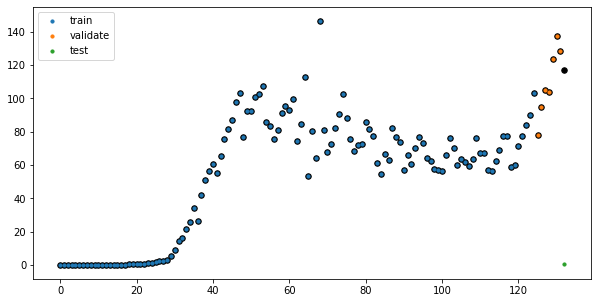

In [7]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.scatter(range(len(X)), X[:,np.where(data.location.unique()=='United States')[0],-1,new_cases_index], s=30,color='k')
ax.scatter(range(len(splits[0])), splits[0][:,np.where(data.location.unique()=='United States')[0],-1,new_cases_index], s=10, label='train')
ax.scatter(range(len(splits[0]), len(splits[0])+len(splits[2])), splits[2][:,np.where(data.location.unique()=='United States')[0],-1,new_cases_index], s=10, label='validate')
ax.scatter(range(len(splits[0])+len(splits[2]), len(X)), X_nn_test[:,np.where(data.location.unique()=='United States')[0],-1,new_cases_index], s=10, label='test')
# ax.plot(data[data.location=='United States'].new_cases_per_million.values[frame_size-1:-1], color='k',alpha=0.2)
plt.legend()
_ = plt.show()

Scatter plots of train, validate, test sets, by plotting all values in black first I can ensure that the points
are correctly ordered and at the correct values because it makes the rest of the points look like they have black borders.
The "missing" data point at the end is because it is in the prediction variable y, and not in X.

In [8]:
scaled_splits, scaling_arrays =  normalize_Xy(splits, feature_range=(0,1.0), 
                                                                  normalization_method='minmax',
                                                                  train_test_only=False,
                                                                  feature_indices=None)

In [9]:
X_nn_train_model = np.concatenate(X_nn_train.reshape(X_nn_train.shape[0], X_nn_train.shape[1], -1), axis=0)[:,:,np.newaxis]
X_nn_validate_model = np.concatenate(X_nn_validate.reshape(X_nn_validate.shape[0], X_nn_validate.shape[1], -1), axis=0)[:,:,np.newaxis]
X_nn_test_model = np.concatenate(X_nn_test.reshape(X_nn_test.shape[0], X_nn_test.shape[1], -1), axis=0)[:,:,np.newaxis]
y_nn_train_model = y_nn_train.ravel()
y_nn_validate_model = y_nn_validate.ravel()
y_nn_test_model = y_nn_test.ravel()

X_for_naive_slicing = np.concatenate(X.reshape(X.shape[0], X.shape[1], -1), axis=0)
n_features = X.shape[-1]
last_day_new_cases_index = np.ravel_multi_index([[frame_size-1],[new_cases_index]],(frame_size, n_features))
y_train_naive = X_for_naive_slicing[train_indices, last_day_new_cases_index].ravel()
y_validate_naive =  X_for_naive_slicing[validate_indices, last_day_new_cases_index].ravel()
y_test_naive =  X_for_naive_slicing[test_indices, last_day_new_cases_index].ravel()

In [56]:
epochs = 10000
learning_rate = 0.001
kernel = 4
N = 8
FC = 8
batch_size = X_nn_train.shape[0]

nn_input = Input(shape=X_nn_train.shape[2:])
flat = Flatten()(nn_input)
dense0 = Dense(int(flat.shape[1].value), 
                use_bias=False,
               )(flat)
dense1 = Dense(1, 
                activation='relu',
                use_bias=False,
               )(dense0)

nn = Model(inputs=nn_input, outputs=dense1)
nn.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate))

In [57]:
nn.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 1)]           0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 28)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 28)                784       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 28        
Total params: 812
Trainable params: 812
Non-trainable params: 0
_________________________________________________________________


In [58]:
X_nn_train_model.shape

(125, 28, 1)

In [11]:
history = nn.fit(X_nn_train_model, y_nn_train_model, epochs=epochs, validation_data=(X_nn_validate_model, y_nn_validate_model), 
          batch_size=batch_size, verbose=0)

Train on 125 samples, validate on 7 samples
Epoch 1/10000
125/125 - 0s - loss: 4287.0986 - val_loss: 13586.6611
Epoch 2/10000
125/125 - 0s - loss: 4287.0991 - val_loss: 13586.6611
Epoch 3/10000
125/125 - 0s - loss: 4287.0986 - val_loss: 13586.6621
Epoch 4/10000
125/125 - 0s - loss: 4287.0986 - val_loss: 13586.6621
Epoch 5/10000
125/125 - 0s - loss: 4287.0986 - val_loss: 13586.6621
Epoch 6/10000
125/125 - 0s - loss: 4287.0986 - val_loss: 13586.6621
Epoch 7/10000
125/125 - 0s - loss: 4287.0991 - val_loss: 13586.6621
Epoch 8/10000
125/125 - 0s - loss: 4287.0986 - val_loss: 13586.6621
Epoch 9/10000
125/125 - 0s - loss: 4287.0986 - val_loss: 13586.6621
Epoch 10/10000
125/125 - 0s - loss: 4287.0981 - val_loss: 13586.6621
Epoch 11/10000
125/125 - 0s - loss: 4287.0986 - val_loss: 13586.6621
Epoch 12/10000
125/125 - 0s - loss: 4287.0991 - val_loss: 13586.6621
Epoch 13/10000
125/125 - 0s - loss: 4287.0986 - val_loss: 13586.6611
Epoch 14/10000
125/125 - 0s - loss: 4287.0986 - val_loss: 13586.6621

Epoch 119/10000
125/125 - 0s - loss: 4238.4370 - val_loss: 13438.8428
Epoch 120/10000
125/125 - 0s - loss: 4226.8652 - val_loss: 13409.8516
Epoch 121/10000
125/125 - 0s - loss: 4214.9438 - val_loss: 13380.1855
Epoch 122/10000
125/125 - 0s - loss: 4202.7520 - val_loss: 13349.9912
Epoch 123/10000
125/125 - 0s - loss: 4190.3486 - val_loss: 13319.3799
Epoch 124/10000
125/125 - 0s - loss: 4177.7808 - val_loss: 13288.4326
Epoch 125/10000
125/125 - 0s - loss: 4165.0815 - val_loss: 13257.2051
Epoch 126/10000
125/125 - 0s - loss: 4152.2729 - val_loss: 13225.7393
Epoch 127/10000
125/125 - 0s - loss: 4139.3726 - val_loss: 13194.0674
Epoch 128/10000
125/125 - 0s - loss: 4126.3936 - val_loss: 13162.2100
Epoch 129/10000
125/125 - 0s - loss: 4113.3457 - val_loss: 13130.1846
Epoch 130/10000
125/125 - 0s - loss: 4100.2363 - val_loss: 13098.0029
Epoch 131/10000
125/125 - 0s - loss: 4087.0710 - val_loss: 13065.6787
Epoch 132/10000
125/125 - 0s - loss: 4073.8540 - val_loss: 13033.2080
Epoch 133/10000
125/

Epoch 237/10000
125/125 - 0s - loss: 2452.4031 - val_loss: 8834.1641
Epoch 238/10000
125/125 - 0s - loss: 2436.6912 - val_loss: 8790.7520
Epoch 239/10000
125/125 - 0s - loss: 2421.0166 - val_loss: 8747.3672
Epoch 240/10000
125/125 - 0s - loss: 2405.3804 - val_loss: 8704.0146
Epoch 241/10000
125/125 - 0s - loss: 2389.7832 - val_loss: 8660.6973
Epoch 242/10000
125/125 - 0s - loss: 2374.2268 - val_loss: 8617.4150
Epoch 243/10000
125/125 - 0s - loss: 2358.7119 - val_loss: 8574.1719
Epoch 244/10000
125/125 - 0s - loss: 2343.2395 - val_loss: 8530.9697
Epoch 245/10000
125/125 - 0s - loss: 2327.8105 - val_loss: 8487.8096
Epoch 246/10000
125/125 - 0s - loss: 2312.4255 - val_loss: 8444.6963
Epoch 247/10000
125/125 - 0s - loss: 2297.0857 - val_loss: 8401.6309
Epoch 248/10000
125/125 - 0s - loss: 2281.7925 - val_loss: 8358.6152
Epoch 249/10000
125/125 - 0s - loss: 2266.5464 - val_loss: 8315.6514
Epoch 250/10000
125/125 - 0s - loss: 2251.3484 - val_loss: 8272.7422
Epoch 251/10000
125/125 - 0s - los

Epoch 356/10000
125/125 - 0s - loss: 1037.5787 - val_loss: 4390.9443
Epoch 357/10000
125/125 - 0s - loss: 1030.4337 - val_loss: 4362.9639
Epoch 358/10000
125/125 - 0s - loss: 1023.3682 - val_loss: 4335.1689
Epoch 359/10000
125/125 - 0s - loss: 1016.3819 - val_loss: 4307.5591
Epoch 360/10000
125/125 - 0s - loss: 1009.4744 - val_loss: 4280.1343
Epoch 361/10000
125/125 - 0s - loss: 1002.6454 - val_loss: 4252.8960
Epoch 362/10000
125/125 - 0s - loss: 995.8947 - val_loss: 4225.8433
Epoch 363/10000
125/125 - 0s - loss: 989.2219 - val_loss: 4198.9761
Epoch 364/10000
125/125 - 0s - loss: 982.6263 - val_loss: 4172.2944
Epoch 365/10000
125/125 - 0s - loss: 976.1080 - val_loss: 4145.7993
Epoch 366/10000
125/125 - 0s - loss: 969.6665 - val_loss: 4119.4888
Epoch 367/10000
125/125 - 0s - loss: 963.3013 - val_loss: 4093.3640
Epoch 368/10000
125/125 - 0s - loss: 957.0119 - val_loss: 4067.4253
Epoch 369/10000
125/125 - 0s - loss: 950.7983 - val_loss: 4041.6711
Epoch 370/10000
125/125 - 0s - loss: 944.6

Epoch 477/10000
125/125 - 0s - loss: 613.8145 - val_loss: 2243.9602
Epoch 478/10000
125/125 - 0s - loss: 612.7191 - val_loss: 2234.8704
Epoch 479/10000
125/125 - 0s - loss: 611.6432 - val_loss: 2225.8853
Epoch 480/10000
125/125 - 0s - loss: 610.5865 - val_loss: 2217.0042
Epoch 481/10000
125/125 - 0s - loss: 609.5485 - val_loss: 2208.2258
Epoch 482/10000
125/125 - 0s - loss: 608.5290 - val_loss: 2199.5491
Epoch 483/10000
125/125 - 0s - loss: 607.5276 - val_loss: 2190.9734
Epoch 484/10000
125/125 - 0s - loss: 606.5438 - val_loss: 2182.4978
Epoch 485/10000
125/125 - 0s - loss: 605.5775 - val_loss: 2174.1208
Epoch 486/10000
125/125 - 0s - loss: 604.6282 - val_loss: 2165.8428
Epoch 487/10000
125/125 - 0s - loss: 603.6956 - val_loss: 2157.6611
Epoch 488/10000
125/125 - 0s - loss: 602.7792 - val_loss: 2149.5764
Epoch 489/10000
125/125 - 0s - loss: 601.8790 - val_loss: 2141.5862
Epoch 490/10000
125/125 - 0s - loss: 600.9944 - val_loss: 2133.6907
Epoch 491/10000
125/125 - 0s - loss: 600.1253 - 

Epoch 598/10000
125/125 - 0s - loss: 551.8802 - val_loss: 1667.1091
Epoch 599/10000
125/125 - 0s - loss: 551.6014 - val_loss: 1665.0930
Epoch 600/10000
125/125 - 0s - loss: 551.3233 - val_loss: 1663.1018
Epoch 601/10000
125/125 - 0s - loss: 551.0461 - val_loss: 1661.1345
Epoch 602/10000
125/125 - 0s - loss: 550.7697 - val_loss: 1659.1906
Epoch 603/10000
125/125 - 0s - loss: 550.4939 - val_loss: 1657.2701
Epoch 604/10000
125/125 - 0s - loss: 550.2188 - val_loss: 1655.3730
Epoch 605/10000
125/125 - 0s - loss: 549.9444 - val_loss: 1653.4980
Epoch 606/10000
125/125 - 0s - loss: 549.6707 - val_loss: 1651.6458
Epoch 607/10000
125/125 - 0s - loss: 549.3975 - val_loss: 1649.8156
Epoch 608/10000
125/125 - 0s - loss: 549.1250 - val_loss: 1648.0068
Epoch 609/10000
125/125 - 0s - loss: 548.8531 - val_loss: 1646.2196
Epoch 610/10000
125/125 - 0s - loss: 548.5817 - val_loss: 1644.4531
Epoch 611/10000
125/125 - 0s - loss: 548.3107 - val_loss: 1642.7078
Epoch 612/10000
125/125 - 0s - loss: 548.0405 - 

Epoch 719/10000
125/125 - 0s - loss: 520.0005 - val_loss: 1528.1748
Epoch 720/10000
125/125 - 0s - loss: 519.7379 - val_loss: 1527.4926
Epoch 721/10000
125/125 - 0s - loss: 519.4752 - val_loss: 1526.8129
Epoch 722/10000
125/125 - 0s - loss: 519.2126 - val_loss: 1526.1367
Epoch 723/10000
125/125 - 0s - loss: 518.9499 - val_loss: 1525.4635
Epoch 724/10000
125/125 - 0s - loss: 518.6870 - val_loss: 1524.7932
Epoch 725/10000
125/125 - 0s - loss: 518.4241 - val_loss: 1524.1263
Epoch 726/10000
125/125 - 0s - loss: 518.1612 - val_loss: 1523.4620
Epoch 727/10000
125/125 - 0s - loss: 517.8981 - val_loss: 1522.8008
Epoch 728/10000
125/125 - 0s - loss: 517.6351 - val_loss: 1522.1426
Epoch 729/10000
125/125 - 0s - loss: 517.3719 - val_loss: 1521.4869
Epoch 730/10000
125/125 - 0s - loss: 517.1088 - val_loss: 1520.8340
Epoch 731/10000
125/125 - 0s - loss: 516.8454 - val_loss: 1520.1838
Epoch 732/10000
125/125 - 0s - loss: 516.5820 - val_loss: 1519.5364
Epoch 733/10000
125/125 - 0s - loss: 516.3186 - 

Epoch 840/10000
125/125 - 0s - loss: 487.7648 - val_loss: 1457.7537
Epoch 841/10000
125/125 - 0s - loss: 487.4950 - val_loss: 1457.2155
Epoch 842/10000
125/125 - 0s - loss: 487.2251 - val_loss: 1456.6771
Epoch 843/10000
125/125 - 0s - loss: 486.9550 - val_loss: 1456.1388
Epoch 844/10000
125/125 - 0s - loss: 486.6851 - val_loss: 1455.6007
Epoch 845/10000
125/125 - 0s - loss: 486.4150 - val_loss: 1455.0632
Epoch 846/10000
125/125 - 0s - loss: 486.1450 - val_loss: 1454.5254
Epoch 847/10000
125/125 - 0s - loss: 485.8748 - val_loss: 1453.9877
Epoch 848/10000
125/125 - 0s - loss: 485.6046 - val_loss: 1453.4503
Epoch 849/10000
125/125 - 0s - loss: 485.3344 - val_loss: 1452.9131
Epoch 850/10000
125/125 - 0s - loss: 485.0641 - val_loss: 1452.3759
Epoch 851/10000
125/125 - 0s - loss: 484.7938 - val_loss: 1451.8387
Epoch 852/10000
125/125 - 0s - loss: 484.5234 - val_loss: 1451.3020
Epoch 853/10000
125/125 - 0s - loss: 484.2529 - val_loss: 1450.7649
Epoch 854/10000
125/125 - 0s - loss: 483.9825 - 

Epoch 961/10000
125/125 - 0s - loss: 454.8477 - val_loss: 1392.7789
Epoch 962/10000
125/125 - 0s - loss: 454.5740 - val_loss: 1392.2390
Epoch 963/10000
125/125 - 0s - loss: 454.3004 - val_loss: 1391.6986
Epoch 964/10000
125/125 - 0s - loss: 454.0268 - val_loss: 1391.1584
Epoch 965/10000
125/125 - 0s - loss: 453.7532 - val_loss: 1390.6180
Epoch 966/10000
125/125 - 0s - loss: 453.4795 - val_loss: 1390.0775
Epoch 967/10000
125/125 - 0s - loss: 453.2058 - val_loss: 1389.5374
Epoch 968/10000
125/125 - 0s - loss: 452.9322 - val_loss: 1388.9963
Epoch 969/10000
125/125 - 0s - loss: 452.6585 - val_loss: 1388.4559
Epoch 970/10000
125/125 - 0s - loss: 452.3848 - val_loss: 1387.9150
Epoch 971/10000
125/125 - 0s - loss: 452.1111 - val_loss: 1387.3741
Epoch 972/10000
125/125 - 0s - loss: 451.8373 - val_loss: 1386.8331
Epoch 973/10000
125/125 - 0s - loss: 451.5636 - val_loss: 1386.2921
Epoch 974/10000
125/125 - 0s - loss: 451.2898 - val_loss: 1385.7511
Epoch 975/10000
125/125 - 0s - loss: 451.0161 - 

Epoch 1081/10000
125/125 - 0s - loss: 421.9936 - val_loss: 1327.3827
Epoch 1082/10000
125/125 - 0s - loss: 421.7202 - val_loss: 1326.8331
Epoch 1083/10000
125/125 - 0s - loss: 421.4470 - val_loss: 1326.2834
Epoch 1084/10000
125/125 - 0s - loss: 421.1737 - val_loss: 1325.7340
Epoch 1085/10000
125/125 - 0s - loss: 420.9006 - val_loss: 1325.1840
Epoch 1086/10000
125/125 - 0s - loss: 420.6274 - val_loss: 1324.6342
Epoch 1087/10000
125/125 - 0s - loss: 420.3542 - val_loss: 1324.0844
Epoch 1088/10000
125/125 - 0s - loss: 420.0811 - val_loss: 1323.5344
Epoch 1089/10000
125/125 - 0s - loss: 419.8078 - val_loss: 1322.9845
Epoch 1090/10000
125/125 - 0s - loss: 419.5348 - val_loss: 1322.4344
Epoch 1091/10000
125/125 - 0s - loss: 419.2617 - val_loss: 1321.8842
Epoch 1092/10000
125/125 - 0s - loss: 418.9887 - val_loss: 1321.3340
Epoch 1093/10000
125/125 - 0s - loss: 418.7156 - val_loss: 1320.7838
Epoch 1094/10000
125/125 - 0s - loss: 418.4426 - val_loss: 1320.2335
Epoch 1095/10000
125/125 - 0s - lo

Epoch 1200/10000
125/125 - 0s - loss: 389.7036 - val_loss: 1261.5906
Epoch 1201/10000
125/125 - 0s - loss: 389.4351 - val_loss: 1261.0349
Epoch 1202/10000
125/125 - 0s - loss: 389.1665 - val_loss: 1260.4795
Epoch 1203/10000
125/125 - 0s - loss: 388.8980 - val_loss: 1259.9237
Epoch 1204/10000
125/125 - 0s - loss: 388.6297 - val_loss: 1259.3680
Epoch 1205/10000
125/125 - 0s - loss: 388.3613 - val_loss: 1258.8123
Epoch 1206/10000
125/125 - 0s - loss: 388.0930 - val_loss: 1258.2566
Epoch 1207/10000
125/125 - 0s - loss: 387.8247 - val_loss: 1257.7006
Epoch 1208/10000
125/125 - 0s - loss: 387.5566 - val_loss: 1257.1447
Epoch 1209/10000
125/125 - 0s - loss: 387.2885 - val_loss: 1256.5887
Epoch 1210/10000
125/125 - 0s - loss: 387.0205 - val_loss: 1256.0330
Epoch 1211/10000
125/125 - 0s - loss: 386.7525 - val_loss: 1255.4768
Epoch 1212/10000
125/125 - 0s - loss: 386.4846 - val_loss: 1254.9210
Epoch 1213/10000
125/125 - 0s - loss: 386.2167 - val_loss: 1254.3649
Epoch 1214/10000
125/125 - 0s - lo

Epoch 1319/10000
125/125 - 0s - loss: 358.2589 - val_loss: 1195.3063
Epoch 1320/10000
125/125 - 0s - loss: 358.0000 - val_loss: 1194.7488
Epoch 1321/10000
125/125 - 0s - loss: 357.7412 - val_loss: 1194.1906
Epoch 1322/10000
125/125 - 0s - loss: 357.4825 - val_loss: 1193.6329
Epoch 1323/10000
125/125 - 0s - loss: 357.2239 - val_loss: 1193.0753
Epoch 1324/10000
125/125 - 0s - loss: 356.9654 - val_loss: 1192.5176
Epoch 1325/10000
125/125 - 0s - loss: 356.7070 - val_loss: 1191.9601
Epoch 1326/10000
125/125 - 0s - loss: 356.4487 - val_loss: 1191.4022
Epoch 1327/10000
125/125 - 0s - loss: 356.1905 - val_loss: 1190.8445
Epoch 1328/10000
125/125 - 0s - loss: 355.9324 - val_loss: 1190.2869
Epoch 1329/10000
125/125 - 0s - loss: 355.6745 - val_loss: 1189.7291
Epoch 1330/10000
125/125 - 0s - loss: 355.4166 - val_loss: 1189.1713
Epoch 1331/10000
125/125 - 0s - loss: 355.1588 - val_loss: 1188.6136
Epoch 1332/10000
125/125 - 0s - loss: 354.9012 - val_loss: 1188.0558
Epoch 1333/10000
125/125 - 0s - lo

Epoch 1438/10000
125/125 - 0s - loss: 328.2883 - val_loss: 1129.0276
Epoch 1439/10000
125/125 - 0s - loss: 328.0446 - val_loss: 1128.4720
Epoch 1440/10000
125/125 - 0s - loss: 327.8011 - val_loss: 1127.9165
Epoch 1441/10000
125/125 - 0s - loss: 327.5577 - val_loss: 1127.3615
Epoch 1442/10000
125/125 - 0s - loss: 327.3144 - val_loss: 1126.8064
Epoch 1443/10000
125/125 - 0s - loss: 327.0714 - val_loss: 1126.2511
Epoch 1444/10000
125/125 - 0s - loss: 326.8284 - val_loss: 1125.6959
Epoch 1445/10000
125/125 - 0s - loss: 326.5857 - val_loss: 1125.1405
Epoch 1446/10000
125/125 - 0s - loss: 326.3430 - val_loss: 1124.5856
Epoch 1447/10000
125/125 - 0s - loss: 326.1006 - val_loss: 1124.0304
Epoch 1448/10000
125/125 - 0s - loss: 325.8582 - val_loss: 1123.4756
Epoch 1449/10000
125/125 - 0s - loss: 325.6161 - val_loss: 1122.9207
Epoch 1450/10000
125/125 - 0s - loss: 325.3741 - val_loss: 1122.3655
Epoch 1451/10000
125/125 - 0s - loss: 325.1323 - val_loss: 1121.8107
Epoch 1452/10000
125/125 - 0s - lo

Epoch 1557/10000
125/125 - 0s - loss: 300.4694 - val_loss: 1063.3257
Epoch 1558/10000
125/125 - 0s - loss: 300.2467 - val_loss: 1062.7778
Epoch 1559/10000
125/125 - 0s - loss: 300.0242 - val_loss: 1062.2302
Epoch 1560/10000
125/125 - 0s - loss: 299.8019 - val_loss: 1061.6826
Epoch 1561/10000
125/125 - 0s - loss: 299.5797 - val_loss: 1061.1351
Epoch 1562/10000
125/125 - 0s - loss: 299.3578 - val_loss: 1060.5875
Epoch 1563/10000
125/125 - 0s - loss: 299.1360 - val_loss: 1060.0403
Epoch 1564/10000
125/125 - 0s - loss: 298.9145 - val_loss: 1059.4928
Epoch 1565/10000
125/125 - 0s - loss: 298.6932 - val_loss: 1058.9456
Epoch 1566/10000
125/125 - 0s - loss: 298.4721 - val_loss: 1058.3984
Epoch 1567/10000
125/125 - 0s - loss: 298.2512 - val_loss: 1057.8514
Epoch 1568/10000
125/125 - 0s - loss: 298.0304 - val_loss: 1057.3047
Epoch 1569/10000
125/125 - 0s - loss: 297.8099 - val_loss: 1056.7576
Epoch 1570/10000
125/125 - 0s - loss: 297.5896 - val_loss: 1056.2108
Epoch 1571/10000
125/125 - 0s - lo

Epoch 1676/10000
125/125 - 0s - loss: 275.4591 - val_loss: 998.8741
Epoch 1677/10000
125/125 - 0s - loss: 275.2625 - val_loss: 998.3400
Epoch 1678/10000
125/125 - 0s - loss: 275.0661 - val_loss: 997.8058
Epoch 1679/10000
125/125 - 0s - loss: 274.8699 - val_loss: 997.2721
Epoch 1680/10000
125/125 - 0s - loss: 274.6740 - val_loss: 996.7382
Epoch 1681/10000
125/125 - 0s - loss: 274.4783 - val_loss: 996.2046
Epoch 1682/10000
125/125 - 0s - loss: 274.2829 - val_loss: 995.6713
Epoch 1683/10000
125/125 - 0s - loss: 274.0877 - val_loss: 995.1381
Epoch 1684/10000
125/125 - 0s - loss: 273.8927 - val_loss: 994.6047
Epoch 1685/10000
125/125 - 0s - loss: 273.6979 - val_loss: 994.0717
Epoch 1686/10000
125/125 - 0s - loss: 273.5035 - val_loss: 993.5388
Epoch 1687/10000
125/125 - 0s - loss: 273.3093 - val_loss: 993.0062
Epoch 1688/10000
125/125 - 0s - loss: 273.1152 - val_loss: 992.4736
Epoch 1689/10000
125/125 - 0s - loss: 272.9215 - val_loss: 991.9413
Epoch 1690/10000
125/125 - 0s - loss: 272.7279 -

Epoch 1797/10000
125/125 - 0s - loss: 253.4500 - val_loss: 935.4199
Epoch 1798/10000
125/125 - 0s - loss: 253.2835 - val_loss: 934.9067
Epoch 1799/10000
125/125 - 0s - loss: 253.1173 - val_loss: 934.3934
Epoch 1800/10000
125/125 - 0s - loss: 252.9513 - val_loss: 933.8807
Epoch 1801/10000
125/125 - 0s - loss: 252.7856 - val_loss: 933.3682
Epoch 1802/10000
125/125 - 0s - loss: 252.6201 - val_loss: 932.8556
Epoch 1803/10000
125/125 - 0s - loss: 252.4548 - val_loss: 932.3433
Epoch 1804/10000
125/125 - 0s - loss: 252.2899 - val_loss: 931.8314
Epoch 1805/10000
125/125 - 0s - loss: 252.1252 - val_loss: 931.3194
Epoch 1806/10000
125/125 - 0s - loss: 251.9608 - val_loss: 930.8077
Epoch 1807/10000
125/125 - 0s - loss: 251.7966 - val_loss: 930.2964
Epoch 1808/10000
125/125 - 0s - loss: 251.6327 - val_loss: 929.7851
Epoch 1809/10000
125/125 - 0s - loss: 251.4690 - val_loss: 929.2743
Epoch 1810/10000
125/125 - 0s - loss: 251.3056 - val_loss: 928.7633
Epoch 1811/10000
125/125 - 0s - loss: 251.1425 -

Epoch 1918/10000
125/125 - 0s - loss: 235.1746 - val_loss: 874.9297
Epoch 1919/10000
125/125 - 0s - loss: 235.0392 - val_loss: 874.4446
Epoch 1920/10000
125/125 - 0s - loss: 234.9041 - val_loss: 873.9596
Epoch 1921/10000
125/125 - 0s - loss: 234.7691 - val_loss: 873.4748
Epoch 1922/10000
125/125 - 0s - loss: 234.6345 - val_loss: 872.9905
Epoch 1923/10000
125/125 - 0s - loss: 234.5000 - val_loss: 872.5063
Epoch 1924/10000
125/125 - 0s - loss: 234.3659 - val_loss: 872.0223
Epoch 1925/10000
125/125 - 0s - loss: 234.2320 - val_loss: 871.5386
Epoch 1926/10000
125/125 - 0s - loss: 234.0984 - val_loss: 871.0552
Epoch 1927/10000
125/125 - 0s - loss: 233.9649 - val_loss: 870.5723
Epoch 1928/10000
125/125 - 0s - loss: 233.8318 - val_loss: 870.0892
Epoch 1929/10000
125/125 - 0s - loss: 233.6989 - val_loss: 869.6068
Epoch 1930/10000
125/125 - 0s - loss: 233.5663 - val_loss: 869.1243
Epoch 1931/10000
125/125 - 0s - loss: 233.4338 - val_loss: 868.6423
Epoch 1932/10000
125/125 - 0s - loss: 233.3017 -

Epoch 2039/10000
125/125 - 0s - loss: 220.5617 - val_loss: 818.2203
Epoch 2040/10000
125/125 - 0s - loss: 220.4552 - val_loss: 817.7694
Epoch 2041/10000
125/125 - 0s - loss: 220.3490 - val_loss: 817.3188
Epoch 2042/10000
125/125 - 0s - loss: 220.2429 - val_loss: 816.8685
Epoch 2043/10000
125/125 - 0s - loss: 220.1371 - val_loss: 816.4183
Epoch 2044/10000
125/125 - 0s - loss: 220.0315 - val_loss: 815.9684
Epoch 2045/10000
125/125 - 0s - loss: 219.9261 - val_loss: 815.5190
Epoch 2046/10000
125/125 - 0s - loss: 219.8210 - val_loss: 815.0697
Epoch 2047/10000
125/125 - 0s - loss: 219.7161 - val_loss: 814.6208
Epoch 2048/10000
125/125 - 0s - loss: 219.6114 - val_loss: 814.1724
Epoch 2049/10000
125/125 - 0s - loss: 219.5069 - val_loss: 813.7241
Epoch 2050/10000
125/125 - 0s - loss: 219.4026 - val_loss: 813.2762
Epoch 2051/10000
125/125 - 0s - loss: 219.2985 - val_loss: 812.8284
Epoch 2052/10000
125/125 - 0s - loss: 219.1947 - val_loss: 812.3812
Epoch 2053/10000
125/125 - 0s - loss: 219.0911 -

Epoch 2160/10000
125/125 - 0s - loss: 209.1867 - val_loss: 765.9130
Epoch 2161/10000
125/125 - 0s - loss: 209.1044 - val_loss: 765.5003
Epoch 2162/10000
125/125 - 0s - loss: 209.0222 - val_loss: 765.0876
Epoch 2163/10000
125/125 - 0s - loss: 208.9404 - val_loss: 764.6754
Epoch 2164/10000
125/125 - 0s - loss: 208.8586 - val_loss: 764.2635
Epoch 2165/10000
125/125 - 0s - loss: 208.7770 - val_loss: 763.8520
Epoch 2166/10000
125/125 - 0s - loss: 208.6956 - val_loss: 763.4408
Epoch 2167/10000
125/125 - 0s - loss: 208.6144 - val_loss: 763.0298
Epoch 2168/10000
125/125 - 0s - loss: 208.5333 - val_loss: 762.6191
Epoch 2169/10000
125/125 - 0s - loss: 208.4524 - val_loss: 762.2089
Epoch 2170/10000
125/125 - 0s - loss: 208.3717 - val_loss: 761.7989
Epoch 2171/10000
125/125 - 0s - loss: 208.2912 - val_loss: 761.3892
Epoch 2172/10000
125/125 - 0s - loss: 208.2108 - val_loss: 760.9799
Epoch 2173/10000
125/125 - 0s - loss: 208.1306 - val_loss: 760.5710
Epoch 2174/10000
125/125 - 0s - loss: 208.0505 -

Epoch 2281/10000
125/125 - 0s - loss: 200.3810 - val_loss: 718.3022
Epoch 2282/10000
125/125 - 0s - loss: 200.3168 - val_loss: 717.9286
Epoch 2283/10000
125/125 - 0s - loss: 200.2527 - val_loss: 717.5551
Epoch 2284/10000
125/125 - 0s - loss: 200.1888 - val_loss: 717.1816
Epoch 2285/10000
125/125 - 0s - loss: 200.1250 - val_loss: 716.8087
Epoch 2286/10000
125/125 - 0s - loss: 200.0614 - val_loss: 716.4361
Epoch 2287/10000
125/125 - 0s - loss: 199.9978 - val_loss: 716.0638
Epoch 2288/10000
125/125 - 0s - loss: 199.9344 - val_loss: 715.6920
Epoch 2289/10000
125/125 - 0s - loss: 199.8711 - val_loss: 715.3202
Epoch 2290/10000
125/125 - 0s - loss: 199.8079 - val_loss: 714.9487
Epoch 2291/10000
125/125 - 0s - loss: 199.7448 - val_loss: 714.5777
Epoch 2292/10000
125/125 - 0s - loss: 199.6819 - val_loss: 714.2069
Epoch 2293/10000
125/125 - 0s - loss: 199.6190 - val_loss: 713.8365
Epoch 2294/10000
125/125 - 0s - loss: 199.5564 - val_loss: 713.4664
Epoch 2295/10000
125/125 - 0s - loss: 199.4938 -

Epoch 2402/10000
125/125 - 0s - loss: 193.4011 - val_loss: 675.3041
Epoch 2403/10000
125/125 - 0s - loss: 193.3491 - val_loss: 674.9667
Epoch 2404/10000
125/125 - 0s - loss: 193.2971 - val_loss: 674.6299
Epoch 2405/10000
125/125 - 0s - loss: 193.2453 - val_loss: 674.2934
Epoch 2406/10000
125/125 - 0s - loss: 193.1935 - val_loss: 673.9572
Epoch 2407/10000
125/125 - 0s - loss: 193.1418 - val_loss: 673.6212
Epoch 2408/10000
125/125 - 0s - loss: 193.0901 - val_loss: 673.2853
Epoch 2409/10000
125/125 - 0s - loss: 193.0385 - val_loss: 672.9502
Epoch 2410/10000
125/125 - 0s - loss: 192.9871 - val_loss: 672.6151
Epoch 2411/10000
125/125 - 0s - loss: 192.9356 - val_loss: 672.2802
Epoch 2412/10000
125/125 - 0s - loss: 192.8843 - val_loss: 671.9455
Epoch 2413/10000
125/125 - 0s - loss: 192.8330 - val_loss: 671.6112
Epoch 2414/10000
125/125 - 0s - loss: 192.7819 - val_loss: 671.2772
Epoch 2415/10000
125/125 - 0s - loss: 192.7307 - val_loss: 670.9435
Epoch 2416/10000
125/125 - 0s - loss: 192.6797 -

Epoch 2523/10000
125/125 - 0s - loss: 187.5841 - val_loss: 636.4963
Epoch 2524/10000
125/125 - 0s - loss: 187.5394 - val_loss: 636.1913
Epoch 2525/10000
125/125 - 0s - loss: 187.4947 - val_loss: 635.8866
Epoch 2526/10000
125/125 - 0s - loss: 187.4500 - val_loss: 635.5822
Epoch 2527/10000
125/125 - 0s - loss: 187.4054 - val_loss: 635.2778
Epoch 2528/10000
125/125 - 0s - loss: 187.3609 - val_loss: 634.9739
Epoch 2529/10000
125/125 - 0s - loss: 187.3163 - val_loss: 634.6701
Epoch 2530/10000
125/125 - 0s - loss: 187.2719 - val_loss: 634.3666
Epoch 2531/10000
125/125 - 0s - loss: 187.2274 - val_loss: 634.0634
Epoch 2532/10000
125/125 - 0s - loss: 187.1830 - val_loss: 633.7603
Epoch 2533/10000
125/125 - 0s - loss: 187.1387 - val_loss: 633.4575
Epoch 2534/10000
125/125 - 0s - loss: 187.0944 - val_loss: 633.1550
Epoch 2535/10000
125/125 - 0s - loss: 187.0501 - val_loss: 632.8527
Epoch 2536/10000
125/125 - 0s - loss: 187.0059 - val_loss: 632.5505
Epoch 2537/10000
125/125 - 0s - loss: 186.9617 -

Epoch 2644/10000
125/125 - 0s - loss: 182.4344 - val_loss: 601.2368
Epoch 2645/10000
125/125 - 0s - loss: 182.3937 - val_loss: 600.9580
Epoch 2646/10000
125/125 - 0s - loss: 182.3529 - val_loss: 600.6796
Epoch 2647/10000
125/125 - 0s - loss: 182.3121 - val_loss: 600.4012
Epoch 2648/10000
125/125 - 0s - loss: 182.2714 - val_loss: 600.1232
Epoch 2649/10000
125/125 - 0s - loss: 182.2308 - val_loss: 599.8453
Epoch 2650/10000
125/125 - 0s - loss: 182.1901 - val_loss: 599.5677
Epoch 2651/10000
125/125 - 0s - loss: 182.1495 - val_loss: 599.2900
Epoch 2652/10000
125/125 - 0s - loss: 182.1088 - val_loss: 599.0128
Epoch 2653/10000
125/125 - 0s - loss: 182.0683 - val_loss: 598.7357
Epoch 2654/10000
125/125 - 0s - loss: 182.0277 - val_loss: 598.4588
Epoch 2655/10000
125/125 - 0s - loss: 181.9871 - val_loss: 598.1821
Epoch 2656/10000
125/125 - 0s - loss: 181.9466 - val_loss: 597.9055
Epoch 2657/10000
125/125 - 0s - loss: 181.9061 - val_loss: 597.6293
Epoch 2658/10000
125/125 - 0s - loss: 181.8656 -

Epoch 2765/10000
125/125 - 0s - loss: 177.6364 - val_loss: 568.8016
Epoch 2766/10000
125/125 - 0s - loss: 177.5977 - val_loss: 568.5432
Epoch 2767/10000
125/125 - 0s - loss: 177.5590 - val_loss: 568.2851
Epoch 2768/10000
125/125 - 0s - loss: 177.5202 - val_loss: 568.0273
Epoch 2769/10000
125/125 - 0s - loss: 177.4815 - val_loss: 567.7695
Epoch 2770/10000
125/125 - 0s - loss: 177.4428 - val_loss: 567.5118
Epoch 2771/10000
125/125 - 0s - loss: 177.4041 - val_loss: 567.2542
Epoch 2772/10000
125/125 - 0s - loss: 177.3654 - val_loss: 566.9969
Epoch 2773/10000
125/125 - 0s - loss: 177.3268 - val_loss: 566.7394
Epoch 2774/10000
125/125 - 0s - loss: 177.2881 - val_loss: 566.4824
Epoch 2775/10000
125/125 - 0s - loss: 177.2495 - val_loss: 566.2254
Epoch 2776/10000
125/125 - 0s - loss: 177.2109 - val_loss: 565.9687
Epoch 2777/10000
125/125 - 0s - loss: 177.1723 - val_loss: 565.7121
Epoch 2778/10000
125/125 - 0s - loss: 177.1337 - val_loss: 565.4553
Epoch 2779/10000
125/125 - 0s - loss: 177.0951 -

Epoch 2886/10000
125/125 - 0s - loss: 173.0199 - val_loss: 538.5096
Epoch 2887/10000
125/125 - 0s - loss: 172.9822 - val_loss: 538.2664
Epoch 2888/10000
125/125 - 0s - loss: 172.9446 - val_loss: 538.0233
Epoch 2889/10000
125/125 - 0s - loss: 172.9070 - val_loss: 537.7806
Epoch 2890/10000
125/125 - 0s - loss: 172.8693 - val_loss: 537.5377
Epoch 2891/10000
125/125 - 0s - loss: 172.8317 - val_loss: 537.2950
Epoch 2892/10000
125/125 - 0s - loss: 172.7941 - val_loss: 537.0525
Epoch 2893/10000
125/125 - 0s - loss: 172.7565 - val_loss: 536.8102
Epoch 2894/10000
125/125 - 0s - loss: 172.7189 - val_loss: 536.5677
Epoch 2895/10000
125/125 - 0s - loss: 172.6813 - val_loss: 536.3256
Epoch 2896/10000
125/125 - 0s - loss: 172.6437 - val_loss: 536.0833
Epoch 2897/10000
125/125 - 0s - loss: 172.6061 - val_loss: 535.8414
Epoch 2898/10000
125/125 - 0s - loss: 172.5685 - val_loss: 535.5995
Epoch 2899/10000
125/125 - 0s - loss: 172.5310 - val_loss: 535.3576
Epoch 2900/10000
125/125 - 0s - loss: 172.4934 -

Epoch 3007/10000
125/125 - 0s - loss: 168.5114 - val_loss: 509.7989
Epoch 3008/10000
125/125 - 0s - loss: 168.4745 - val_loss: 509.5669
Epoch 3009/10000
125/125 - 0s - loss: 168.4376 - val_loss: 509.3352
Epoch 3010/10000
125/125 - 0s - loss: 168.4007 - val_loss: 509.1033
Epoch 3011/10000
125/125 - 0s - loss: 168.3638 - val_loss: 508.8716
Epoch 3012/10000
125/125 - 0s - loss: 168.3270 - val_loss: 508.6401
Epoch 3013/10000
125/125 - 0s - loss: 168.2902 - val_loss: 508.4086
Epoch 3014/10000
125/125 - 0s - loss: 168.2533 - val_loss: 508.1772
Epoch 3015/10000
125/125 - 0s - loss: 168.2164 - val_loss: 507.9457
Epoch 3016/10000
125/125 - 0s - loss: 168.1796 - val_loss: 507.7145
Epoch 3017/10000
125/125 - 0s - loss: 168.1428 - val_loss: 507.4832
Epoch 3018/10000
125/125 - 0s - loss: 168.1060 - val_loss: 507.2520
Epoch 3019/10000
125/125 - 0s - loss: 168.0691 - val_loss: 507.0210
Epoch 3020/10000
125/125 - 0s - loss: 168.0323 - val_loss: 506.7900
Epoch 3021/10000
125/125 - 0s - loss: 167.9955 -

Epoch 3128/10000
125/125 - 0s - loss: 164.0932 - val_loss: 482.2626
Epoch 3129/10000
125/125 - 0s - loss: 164.0571 - val_loss: 482.0391
Epoch 3130/10000
125/125 - 0s - loss: 164.0210 - val_loss: 481.8158
Epoch 3131/10000
125/125 - 0s - loss: 163.9849 - val_loss: 481.5923
Epoch 3132/10000
125/125 - 0s - loss: 163.9488 - val_loss: 481.3690
Epoch 3133/10000
125/125 - 0s - loss: 163.9127 - val_loss: 481.1458
Epoch 3134/10000
125/125 - 0s - loss: 163.8766 - val_loss: 480.9226
Epoch 3135/10000
125/125 - 0s - loss: 163.8406 - val_loss: 480.6993
Epoch 3136/10000
125/125 - 0s - loss: 163.8045 - val_loss: 480.4765
Epoch 3137/10000
125/125 - 0s - loss: 163.7684 - val_loss: 480.2534
Epoch 3138/10000
125/125 - 0s - loss: 163.7323 - val_loss: 480.0304
Epoch 3139/10000
125/125 - 0s - loss: 163.6963 - val_loss: 479.8077
Epoch 3140/10000
125/125 - 0s - loss: 163.6602 - val_loss: 479.5849
Epoch 3141/10000
125/125 - 0s - loss: 163.6242 - val_loss: 479.3621
Epoch 3142/10000
125/125 - 0s - loss: 163.5882 -

Epoch 3249/10000
125/125 - 0s - loss: 159.7765 - val_loss: 455.6490
Epoch 3250/10000
125/125 - 0s - loss: 159.7413 - val_loss: 455.4326
Epoch 3251/10000
125/125 - 0s - loss: 159.7061 - val_loss: 455.2161
Epoch 3252/10000
125/125 - 0s - loss: 159.6709 - val_loss: 454.9996
Epoch 3253/10000
125/125 - 0s - loss: 159.6358 - val_loss: 454.7833
Epoch 3254/10000
125/125 - 0s - loss: 159.6006 - val_loss: 454.5670
Epoch 3255/10000
125/125 - 0s - loss: 159.5654 - val_loss: 454.3507
Epoch 3256/10000
125/125 - 0s - loss: 159.5303 - val_loss: 454.1347
Epoch 3257/10000
125/125 - 0s - loss: 159.4952 - val_loss: 453.9186
Epoch 3258/10000
125/125 - 0s - loss: 159.4601 - val_loss: 453.7024
Epoch 3259/10000
125/125 - 0s - loss: 159.4249 - val_loss: 453.4863
Epoch 3260/10000
125/125 - 0s - loss: 159.3898 - val_loss: 453.2704
Epoch 3261/10000
125/125 - 0s - loss: 159.3548 - val_loss: 453.0544
Epoch 3262/10000
125/125 - 0s - loss: 159.3197 - val_loss: 452.8386
Epoch 3263/10000
125/125 - 0s - loss: 159.2846 -

Epoch 3370/10000
125/125 - 0s - loss: 155.5853 - val_loss: 429.8416
Epoch 3371/10000
125/125 - 0s - loss: 155.5512 - val_loss: 429.6314
Epoch 3372/10000
125/125 - 0s - loss: 155.5172 - val_loss: 429.4216
Epoch 3373/10000
125/125 - 0s - loss: 155.4832 - val_loss: 429.2116
Epoch 3374/10000
125/125 - 0s - loss: 155.4492 - val_loss: 429.0017
Epoch 3375/10000
125/125 - 0s - loss: 155.4152 - val_loss: 428.7920
Epoch 3376/10000
125/125 - 0s - loss: 155.3812 - val_loss: 428.5823
Epoch 3377/10000
125/125 - 0s - loss: 155.3472 - val_loss: 428.3725
Epoch 3378/10000
125/125 - 0s - loss: 155.3133 - val_loss: 428.1628
Epoch 3379/10000
125/125 - 0s - loss: 155.2793 - val_loss: 427.9533
Epoch 3380/10000
125/125 - 0s - loss: 155.2454 - val_loss: 427.7437
Epoch 3381/10000
125/125 - 0s - loss: 155.2115 - val_loss: 427.5344
Epoch 3382/10000
125/125 - 0s - loss: 155.1776 - val_loss: 427.3249
Epoch 3383/10000
125/125 - 0s - loss: 155.1437 - val_loss: 427.1156
Epoch 3384/10000
125/125 - 0s - loss: 155.1098 -

Epoch 3491/10000
125/125 - 0s - loss: 151.5491 - val_loss: 404.8296
Epoch 3492/10000
125/125 - 0s - loss: 151.5164 - val_loss: 404.6264
Epoch 3493/10000
125/125 - 0s - loss: 151.4838 - val_loss: 404.4233
Epoch 3494/10000
125/125 - 0s - loss: 151.4512 - val_loss: 404.2201
Epoch 3495/10000
125/125 - 0s - loss: 151.4186 - val_loss: 404.0170
Epoch 3496/10000
125/125 - 0s - loss: 151.3861 - val_loss: 403.8140
Epoch 3497/10000
125/125 - 0s - loss: 151.3535 - val_loss: 403.6110
Epoch 3498/10000
125/125 - 0s - loss: 151.3210 - val_loss: 403.4082
Epoch 3499/10000
125/125 - 0s - loss: 151.2884 - val_loss: 403.2053
Epoch 3500/10000
125/125 - 0s - loss: 151.2559 - val_loss: 403.0025
Epoch 3501/10000
125/125 - 0s - loss: 151.2234 - val_loss: 402.7998
Epoch 3502/10000
125/125 - 0s - loss: 151.1909 - val_loss: 402.5970
Epoch 3503/10000
125/125 - 0s - loss: 151.1584 - val_loss: 402.3945
Epoch 3504/10000
125/125 - 0s - loss: 151.1259 - val_loss: 402.1919
Epoch 3505/10000
125/125 - 0s - loss: 151.0935 -

Epoch 3612/10000
125/125 - 0s - loss: 147.6983 - val_loss: 380.6787
Epoch 3613/10000
125/125 - 0s - loss: 147.6673 - val_loss: 380.4830
Epoch 3614/10000
125/125 - 0s - loss: 147.6363 - val_loss: 380.2874
Epoch 3615/10000
125/125 - 0s - loss: 147.6054 - val_loss: 380.0916
Epoch 3616/10000
125/125 - 0s - loss: 147.5744 - val_loss: 379.8963
Epoch 3617/10000
125/125 - 0s - loss: 147.5435 - val_loss: 379.7008
Epoch 3618/10000
125/125 - 0s - loss: 147.5126 - val_loss: 379.5054
Epoch 3619/10000
125/125 - 0s - loss: 147.4818 - val_loss: 379.3101
Epoch 3620/10000
125/125 - 0s - loss: 147.4509 - val_loss: 379.1148
Epoch 3621/10000
125/125 - 0s - loss: 147.4201 - val_loss: 378.9197
Epoch 3622/10000
125/125 - 0s - loss: 147.3892 - val_loss: 378.7246
Epoch 3623/10000
125/125 - 0s - loss: 147.3584 - val_loss: 378.5295
Epoch 3624/10000
125/125 - 0s - loss: 147.3275 - val_loss: 378.3345
Epoch 3625/10000
125/125 - 0s - loss: 147.2968 - val_loss: 378.1395
Epoch 3626/10000
125/125 - 0s - loss: 147.2660 -

Epoch 3733/10000
125/125 - 0s - loss: 144.0615 - val_loss: 357.5018
Epoch 3734/10000
125/125 - 0s - loss: 144.0324 - val_loss: 357.3147
Epoch 3735/10000
125/125 - 0s - loss: 144.0033 - val_loss: 357.1277
Epoch 3736/10000
125/125 - 0s - loss: 143.9743 - val_loss: 356.9406
Epoch 3737/10000
125/125 - 0s - loss: 143.9452 - val_loss: 356.7538
Epoch 3738/10000
125/125 - 0s - loss: 143.9162 - val_loss: 356.5670
Epoch 3739/10000
125/125 - 0s - loss: 143.8872 - val_loss: 356.3804
Epoch 3740/10000
125/125 - 0s - loss: 143.8582 - val_loss: 356.1936
Epoch 3741/10000
125/125 - 0s - loss: 143.8292 - val_loss: 356.0071
Epoch 3742/10000
125/125 - 0s - loss: 143.8002 - val_loss: 355.8206
Epoch 3743/10000
125/125 - 0s - loss: 143.7713 - val_loss: 355.6342
Epoch 3744/10000
125/125 - 0s - loss: 143.7424 - val_loss: 355.4479
Epoch 3745/10000
125/125 - 0s - loss: 143.7135 - val_loss: 355.2616
Epoch 3746/10000
125/125 - 0s - loss: 143.6846 - val_loss: 355.0754
Epoch 3747/10000
125/125 - 0s - loss: 143.6557 -

Epoch 3854/10000
125/125 - 0s - loss: 140.6637 - val_loss: 335.4368
Epoch 3855/10000
125/125 - 0s - loss: 140.6366 - val_loss: 335.2596
Epoch 3856/10000
125/125 - 0s - loss: 140.6096 - val_loss: 335.0823
Epoch 3857/10000
125/125 - 0s - loss: 140.5826 - val_loss: 334.9051
Epoch 3858/10000
125/125 - 0s - loss: 140.5556 - val_loss: 334.7279
Epoch 3859/10000
125/125 - 0s - loss: 140.5287 - val_loss: 334.5510
Epoch 3860/10000
125/125 - 0s - loss: 140.5018 - val_loss: 334.3741
Epoch 3861/10000
125/125 - 0s - loss: 140.4748 - val_loss: 334.1973
Epoch 3862/10000
125/125 - 0s - loss: 140.4480 - val_loss: 334.0207
Epoch 3863/10000
125/125 - 0s - loss: 140.4210 - val_loss: 333.8440
Epoch 3864/10000
125/125 - 0s - loss: 140.3942 - val_loss: 333.6675
Epoch 3865/10000
125/125 - 0s - loss: 140.3673 - val_loss: 333.4910
Epoch 3866/10000
125/125 - 0s - loss: 140.3405 - val_loss: 333.3145
Epoch 3867/10000
125/125 - 0s - loss: 140.3137 - val_loss: 333.1382
Epoch 3868/10000
125/125 - 0s - loss: 140.2869 -

Epoch 3975/10000
125/125 - 0s - loss: 137.5238 - val_loss: 314.6262
Epoch 3976/10000
125/125 - 0s - loss: 137.4989 - val_loss: 314.4598
Epoch 3977/10000
125/125 - 0s - loss: 137.4741 - val_loss: 314.2935
Epoch 3978/10000
125/125 - 0s - loss: 137.4493 - val_loss: 314.1273
Epoch 3979/10000
125/125 - 0s - loss: 137.4245 - val_loss: 313.9612
Epoch 3980/10000
125/125 - 0s - loss: 137.3998 - val_loss: 313.7952
Epoch 3981/10000
125/125 - 0s - loss: 137.3750 - val_loss: 313.6292
Epoch 3982/10000
125/125 - 0s - loss: 137.3503 - val_loss: 313.4634
Epoch 3983/10000
125/125 - 0s - loss: 137.3256 - val_loss: 313.2977
Epoch 3984/10000
125/125 - 0s - loss: 137.3009 - val_loss: 313.1320
Epoch 3985/10000
125/125 - 0s - loss: 137.2762 - val_loss: 312.9666
Epoch 3986/10000
125/125 - 0s - loss: 137.2516 - val_loss: 312.8011
Epoch 3987/10000
125/125 - 0s - loss: 137.2270 - val_loss: 312.6358
Epoch 3988/10000
125/125 - 0s - loss: 137.2023 - val_loss: 312.4706
Epoch 3989/10000
125/125 - 0s - loss: 137.1777 -

Epoch 4096/10000
125/125 - 0s - loss: 134.6533 - val_loss: 295.2020
Epoch 4097/10000
125/125 - 0s - loss: 134.6307 - val_loss: 295.0476
Epoch 4098/10000
125/125 - 0s - loss: 134.6081 - val_loss: 294.8933
Epoch 4099/10000
125/125 - 0s - loss: 134.5856 - val_loss: 294.7390
Epoch 4100/10000
125/125 - 0s - loss: 134.5630 - val_loss: 294.5849
Epoch 4101/10000
125/125 - 0s - loss: 134.5405 - val_loss: 294.4308
Epoch 4102/10000
125/125 - 0s - loss: 134.5180 - val_loss: 294.2769
Epoch 4103/10000
125/125 - 0s - loss: 134.4956 - val_loss: 294.1231
Epoch 4104/10000
125/125 - 0s - loss: 134.4731 - val_loss: 293.9693
Epoch 4105/10000
125/125 - 0s - loss: 134.4506 - val_loss: 293.8157
Epoch 4106/10000
125/125 - 0s - loss: 134.4283 - val_loss: 293.6621
Epoch 4107/10000
125/125 - 0s - loss: 134.4059 - val_loss: 293.5088
Epoch 4108/10000
125/125 - 0s - loss: 134.3835 - val_loss: 293.3556
Epoch 4109/10000
125/125 - 0s - loss: 134.3611 - val_loss: 293.2024
Epoch 4110/10000
125/125 - 0s - loss: 134.3387 -

Epoch 4217/10000
125/125 - 0s - loss: 132.0548 - val_loss: 277.2737
Epoch 4218/10000
125/125 - 0s - loss: 132.0345 - val_loss: 277.1319
Epoch 4219/10000
125/125 - 0s - loss: 132.0141 - val_loss: 276.9902
Epoch 4220/10000
125/125 - 0s - loss: 131.9938 - val_loss: 276.8489
Epoch 4221/10000
125/125 - 0s - loss: 131.9735 - val_loss: 276.7075
Epoch 4222/10000
125/125 - 0s - loss: 131.9532 - val_loss: 276.5661
Epoch 4223/10000
125/125 - 0s - loss: 131.9330 - val_loss: 276.4248
Epoch 4224/10000
125/125 - 0s - loss: 131.9127 - val_loss: 276.2839
Epoch 4225/10000
125/125 - 0s - loss: 131.8925 - val_loss: 276.1429
Epoch 4226/10000
125/125 - 0s - loss: 131.8723 - val_loss: 276.0020
Epoch 4227/10000
125/125 - 0s - loss: 131.8521 - val_loss: 275.8613
Epoch 4228/10000
125/125 - 0s - loss: 131.8319 - val_loss: 275.7207
Epoch 4229/10000
125/125 - 0s - loss: 131.8118 - val_loss: 275.5802
Epoch 4230/10000
125/125 - 0s - loss: 131.7916 - val_loss: 275.4398
Epoch 4231/10000
125/125 - 0s - loss: 131.7715 -

Epoch 4338/10000
125/125 - 0s - loss: 129.7216 - val_loss: 260.9175
Epoch 4339/10000
125/125 - 0s - loss: 129.7034 - val_loss: 260.7890
Epoch 4340/10000
125/125 - 0s - loss: 129.6853 - val_loss: 260.6606
Epoch 4341/10000
125/125 - 0s - loss: 129.6671 - val_loss: 260.5323
Epoch 4342/10000
125/125 - 0s - loss: 129.6489 - val_loss: 260.4042
Epoch 4343/10000
125/125 - 0s - loss: 129.6307 - val_loss: 260.2761
Epoch 4344/10000
125/125 - 0s - loss: 129.6126 - val_loss: 260.1480
Epoch 4345/10000
125/125 - 0s - loss: 129.5945 - val_loss: 260.0203
Epoch 4346/10000
125/125 - 0s - loss: 129.5764 - val_loss: 259.8926
Epoch 4347/10000
125/125 - 0s - loss: 129.5583 - val_loss: 259.7650
Epoch 4348/10000
125/125 - 0s - loss: 129.5403 - val_loss: 259.6375
Epoch 4349/10000
125/125 - 0s - loss: 129.5222 - val_loss: 259.5101
Epoch 4350/10000
125/125 - 0s - loss: 129.5042 - val_loss: 259.3829
Epoch 4351/10000
125/125 - 0s - loss: 129.4862 - val_loss: 259.2558
Epoch 4352/10000
125/125 - 0s - loss: 129.4682 -

Epoch 4459/10000
125/125 - 0s - loss: 127.6380 - val_loss: 246.1720
Epoch 4460/10000
125/125 - 0s - loss: 127.6217 - val_loss: 246.0568
Epoch 4461/10000
125/125 - 0s - loss: 127.6055 - val_loss: 245.9418
Epoch 4462/10000
125/125 - 0s - loss: 127.5893 - val_loss: 245.8267
Epoch 4463/10000
125/125 - 0s - loss: 127.5731 - val_loss: 245.7121
Epoch 4464/10000
125/125 - 0s - loss: 127.5569 - val_loss: 245.5973
Epoch 4465/10000
125/125 - 0s - loss: 127.5408 - val_loss: 245.4827
Epoch 4466/10000
125/125 - 0s - loss: 127.5246 - val_loss: 245.3683
Epoch 4467/10000
125/125 - 0s - loss: 127.5085 - val_loss: 245.2539
Epoch 4468/10000
125/125 - 0s - loss: 127.4924 - val_loss: 245.1396
Epoch 4469/10000
125/125 - 0s - loss: 127.4763 - val_loss: 245.0256
Epoch 4470/10000
125/125 - 0s - loss: 127.4602 - val_loss: 244.9115
Epoch 4471/10000
125/125 - 0s - loss: 127.4441 - val_loss: 244.7975
Epoch 4472/10000
125/125 - 0s - loss: 127.4280 - val_loss: 244.6838
Epoch 4473/10000
125/125 - 0s - loss: 127.4120 -

Epoch 4580/10000
125/125 - 0s - loss: 125.7804 - val_loss: 233.0330
Epoch 4581/10000
125/125 - 0s - loss: 125.7659 - val_loss: 232.9309
Epoch 4582/10000
125/125 - 0s - loss: 125.7514 - val_loss: 232.8291
Epoch 4583/10000
125/125 - 0s - loss: 125.7369 - val_loss: 232.7273
Epoch 4584/10000
125/125 - 0s - loss: 125.7225 - val_loss: 232.6256
Epoch 4585/10000
125/125 - 0s - loss: 125.7080 - val_loss: 232.5240
Epoch 4586/10000
125/125 - 0s - loss: 125.6936 - val_loss: 232.4226
Epoch 4587/10000
125/125 - 0s - loss: 125.6792 - val_loss: 232.3212
Epoch 4588/10000
125/125 - 0s - loss: 125.6648 - val_loss: 232.2200
Epoch 4589/10000
125/125 - 0s - loss: 125.6505 - val_loss: 232.1189
Epoch 4590/10000
125/125 - 0s - loss: 125.6361 - val_loss: 232.0178
Epoch 4591/10000
125/125 - 0s - loss: 125.6217 - val_loss: 231.9169
Epoch 4592/10000
125/125 - 0s - loss: 125.6074 - val_loss: 231.8160
Epoch 4593/10000
125/125 - 0s - loss: 125.5930 - val_loss: 231.7154
Epoch 4594/10000
125/125 - 0s - loss: 125.5787 -

Epoch 4701/10000
125/125 - 0s - loss: 124.1199 - val_loss: 221.4554
Epoch 4702/10000
125/125 - 0s - loss: 124.1070 - val_loss: 221.3660
Epoch 4703/10000
125/125 - 0s - loss: 124.0940 - val_loss: 221.2767
Epoch 4704/10000
125/125 - 0s - loss: 124.0810 - val_loss: 221.1874
Epoch 4705/10000
125/125 - 0s - loss: 124.0681 - val_loss: 221.0984
Epoch 4706/10000
125/125 - 0s - loss: 124.0551 - val_loss: 221.0093
Epoch 4707/10000
125/125 - 0s - loss: 124.0422 - val_loss: 220.9205
Epoch 4708/10000
125/125 - 0s - loss: 124.0293 - val_loss: 220.8318
Epoch 4709/10000
125/125 - 0s - loss: 124.0163 - val_loss: 220.7431
Epoch 4710/10000
125/125 - 0s - loss: 124.0035 - val_loss: 220.6545
Epoch 4711/10000
125/125 - 0s - loss: 123.9906 - val_loss: 220.5659
Epoch 4712/10000
125/125 - 0s - loss: 123.9777 - val_loss: 220.4777
Epoch 4713/10000
125/125 - 0s - loss: 123.9648 - val_loss: 220.3894
Epoch 4714/10000
125/125 - 0s - loss: 123.9520 - val_loss: 220.3013
Epoch 4715/10000
125/125 - 0s - loss: 123.9391 -

Epoch 4822/10000
125/125 - 0s - loss: 122.6252 - val_loss: 211.3563
Epoch 4823/10000
125/125 - 0s - loss: 122.6135 - val_loss: 211.2787
Epoch 4824/10000
125/125 - 0s - loss: 122.6017 - val_loss: 211.2012
Epoch 4825/10000
125/125 - 0s - loss: 122.5900 - val_loss: 211.1237
Epoch 4826/10000
125/125 - 0s - loss: 122.5783 - val_loss: 211.0465
Epoch 4827/10000
125/125 - 0s - loss: 122.5665 - val_loss: 210.9693
Epoch 4828/10000
125/125 - 0s - loss: 122.5548 - val_loss: 210.8921
Epoch 4829/10000
125/125 - 0s - loss: 122.5432 - val_loss: 210.8151
Epoch 4830/10000
125/125 - 0s - loss: 122.5315 - val_loss: 210.7382
Epoch 4831/10000
125/125 - 0s - loss: 122.5198 - val_loss: 210.6613
Epoch 4832/10000
125/125 - 0s - loss: 122.5081 - val_loss: 210.5844
Epoch 4833/10000
125/125 - 0s - loss: 122.4964 - val_loss: 210.5078
Epoch 4834/10000
125/125 - 0s - loss: 122.4848 - val_loss: 210.4312
Epoch 4835/10000
125/125 - 0s - loss: 122.4732 - val_loss: 210.3547
Epoch 4836/10000
125/125 - 0s - loss: 122.4615 -

Epoch 4943/10000
125/125 - 0s - loss: 121.2648 - val_loss: 202.6220
Epoch 4944/10000
125/125 - 0s - loss: 121.2541 - val_loss: 202.5551
Epoch 4945/10000
125/125 - 0s - loss: 121.2433 - val_loss: 202.4884
Epoch 4946/10000
125/125 - 0s - loss: 121.2326 - val_loss: 202.4217
Epoch 4947/10000
125/125 - 0s - loss: 121.2218 - val_loss: 202.3551
Epoch 4948/10000
125/125 - 0s - loss: 121.2111 - val_loss: 202.2884
Epoch 4949/10000
125/125 - 0s - loss: 121.2003 - val_loss: 202.2221
Epoch 4950/10000
125/125 - 0s - loss: 121.1896 - val_loss: 202.1557
Epoch 4951/10000
125/125 - 0s - loss: 121.1789 - val_loss: 202.0894
Epoch 4952/10000
125/125 - 0s - loss: 121.1682 - val_loss: 202.0232
Epoch 4953/10000
125/125 - 0s - loss: 121.1575 - val_loss: 201.9571
Epoch 4954/10000
125/125 - 0s - loss: 121.1468 - val_loss: 201.8910
Epoch 4955/10000
125/125 - 0s - loss: 121.1361 - val_loss: 201.8252
Epoch 4956/10000
125/125 - 0s - loss: 121.1255 - val_loss: 201.7592
Epoch 4957/10000
125/125 - 0s - loss: 121.1148 -

Epoch 5064/10000
125/125 - 0s - loss: 120.0101 - val_loss: 195.1162
Epoch 5065/10000
125/125 - 0s - loss: 120.0001 - val_loss: 195.0588
Epoch 5066/10000
125/125 - 0s - loss: 119.9902 - val_loss: 195.0017
Epoch 5067/10000
125/125 - 0s - loss: 119.9801 - val_loss: 194.9444
Epoch 5068/10000
125/125 - 0s - loss: 119.9702 - val_loss: 194.8873
Epoch 5069/10000
125/125 - 0s - loss: 119.9602 - val_loss: 194.8302
Epoch 5070/10000
125/125 - 0s - loss: 119.9502 - val_loss: 194.7733
Epoch 5071/10000
125/125 - 0s - loss: 119.9403 - val_loss: 194.7164
Epoch 5072/10000
125/125 - 0s - loss: 119.9303 - val_loss: 194.6597
Epoch 5073/10000
125/125 - 0s - loss: 119.9203 - val_loss: 194.6030
Epoch 5074/10000
125/125 - 0s - loss: 119.9104 - val_loss: 194.5462
Epoch 5075/10000
125/125 - 0s - loss: 119.9004 - val_loss: 194.4896
Epoch 5076/10000
125/125 - 0s - loss: 119.8905 - val_loss: 194.4331
Epoch 5077/10000
125/125 - 0s - loss: 119.8806 - val_loss: 194.3767
Epoch 5078/10000
125/125 - 0s - loss: 119.8706 -

Epoch 5185/10000
125/125 - 0s - loss: 118.8368 - val_loss: 188.6891
Epoch 5186/10000
125/125 - 0s - loss: 118.8274 - val_loss: 188.6401
Epoch 5187/10000
125/125 - 0s - loss: 118.8179 - val_loss: 188.5911
Epoch 5188/10000
125/125 - 0s - loss: 118.8086 - val_loss: 188.5423
Epoch 5189/10000
125/125 - 0s - loss: 118.7991 - val_loss: 188.4934
Epoch 5190/10000
125/125 - 0s - loss: 118.7897 - val_loss: 188.4446
Epoch 5191/10000
125/125 - 0s - loss: 118.7803 - val_loss: 188.3958
Epoch 5192/10000
125/125 - 0s - loss: 118.7710 - val_loss: 188.3471
Epoch 5193/10000
125/125 - 0s - loss: 118.7616 - val_loss: 188.2985
Epoch 5194/10000
125/125 - 0s - loss: 118.7522 - val_loss: 188.2500
Epoch 5195/10000
125/125 - 0s - loss: 118.7428 - val_loss: 188.2016
Epoch 5196/10000
125/125 - 0s - loss: 118.7334 - val_loss: 188.1532
Epoch 5197/10000
125/125 - 0s - loss: 118.7241 - val_loss: 188.1048
Epoch 5198/10000
125/125 - 0s - loss: 118.7147 - val_loss: 188.0565
Epoch 5199/10000
125/125 - 0s - loss: 118.7053 -

Epoch 5306/10000
125/125 - 0s - loss: 117.7257 - val_loss: 183.1873
Epoch 5307/10000
125/125 - 0s - loss: 117.7167 - val_loss: 183.1453
Epoch 5308/10000
125/125 - 0s - loss: 117.7077 - val_loss: 183.1032
Epoch 5309/10000
125/125 - 0s - loss: 117.6988 - val_loss: 183.0614
Epoch 5310/10000
125/125 - 0s - loss: 117.6898 - val_loss: 183.0194
Epoch 5311/10000
125/125 - 0s - loss: 117.6808 - val_loss: 182.9776
Epoch 5312/10000
125/125 - 0s - loss: 117.6719 - val_loss: 182.9359
Epoch 5313/10000
125/125 - 0s - loss: 117.6629 - val_loss: 182.8941
Epoch 5314/10000
125/125 - 0s - loss: 117.6540 - val_loss: 182.8525
Epoch 5315/10000
125/125 - 0s - loss: 117.6451 - val_loss: 182.8109
Epoch 5316/10000
125/125 - 0s - loss: 117.6361 - val_loss: 182.7693
Epoch 5317/10000
125/125 - 0s - loss: 117.6272 - val_loss: 182.7278
Epoch 5318/10000
125/125 - 0s - loss: 117.6183 - val_loss: 182.6863
Epoch 5319/10000
125/125 - 0s - loss: 117.6093 - val_loss: 182.6449
Epoch 5320/10000
125/125 - 0s - loss: 117.6004 -

Epoch 5427/10000
125/125 - 0s - loss: 116.6629 - val_loss: 178.4607
Epoch 5428/10000
125/125 - 0s - loss: 116.6543 - val_loss: 178.4245
Epoch 5429/10000
125/125 - 0s - loss: 116.6457 - val_loss: 178.3883
Epoch 5430/10000
125/125 - 0s - loss: 116.6371 - val_loss: 178.3522
Epoch 5431/10000
125/125 - 0s - loss: 116.6285 - val_loss: 178.3161
Epoch 5432/10000
125/125 - 0s - loss: 116.6199 - val_loss: 178.2800
Epoch 5433/10000
125/125 - 0s - loss: 116.6113 - val_loss: 178.2440
Epoch 5434/10000
125/125 - 0s - loss: 116.6027 - val_loss: 178.2079
Epoch 5435/10000
125/125 - 0s - loss: 116.5941 - val_loss: 178.1721
Epoch 5436/10000
125/125 - 0s - loss: 116.5855 - val_loss: 178.1362
Epoch 5437/10000
125/125 - 0s - loss: 116.5769 - val_loss: 178.1004
Epoch 5438/10000
125/125 - 0s - loss: 116.5684 - val_loss: 178.0646
Epoch 5439/10000
125/125 - 0s - loss: 116.5598 - val_loss: 178.0288
Epoch 5440/10000
125/125 - 0s - loss: 116.5512 - val_loss: 177.9931
Epoch 5441/10000
125/125 - 0s - loss: 116.5426 -

Epoch 5548/10000
125/125 - 0s - loss: 115.6395 - val_loss: 174.3698
Epoch 5549/10000
125/125 - 0s - loss: 115.6312 - val_loss: 174.3383
Epoch 5550/10000
125/125 - 0s - loss: 115.6229 - val_loss: 174.3067
Epoch 5551/10000
125/125 - 0s - loss: 115.6146 - val_loss: 174.2753
Epoch 5552/10000
125/125 - 0s - loss: 115.6063 - val_loss: 174.2439
Epoch 5553/10000
125/125 - 0s - loss: 115.5980 - val_loss: 174.2125
Epoch 5554/10000
125/125 - 0s - loss: 115.5897 - val_loss: 174.1811
Epoch 5555/10000
125/125 - 0s - loss: 115.5814 - val_loss: 174.1498
Epoch 5556/10000
125/125 - 0s - loss: 115.5731 - val_loss: 174.1185
Epoch 5557/10000
125/125 - 0s - loss: 115.5648 - val_loss: 174.0874
Epoch 5558/10000
125/125 - 0s - loss: 115.5565 - val_loss: 174.0562
Epoch 5559/10000
125/125 - 0s - loss: 115.5482 - val_loss: 174.0250
Epoch 5560/10000
125/125 - 0s - loss: 115.5400 - val_loss: 173.9939
Epoch 5561/10000
125/125 - 0s - loss: 115.5317 - val_loss: 173.9628
Epoch 5562/10000
125/125 - 0s - loss: 115.5234 -

Epoch 5669/10000
125/125 - 0s - loss: 114.6503 - val_loss: 170.7898
Epoch 5670/10000
125/125 - 0s - loss: 114.6423 - val_loss: 170.7620
Epoch 5671/10000
125/125 - 0s - loss: 114.6342 - val_loss: 170.7343
Epoch 5672/10000
125/125 - 0s - loss: 114.6262 - val_loss: 170.7065
Epoch 5673/10000
125/125 - 0s - loss: 114.6182 - val_loss: 170.6788
Epoch 5674/10000
125/125 - 0s - loss: 114.6101 - val_loss: 170.6512
Epoch 5675/10000
125/125 - 0s - loss: 114.6021 - val_loss: 170.6236
Epoch 5676/10000
125/125 - 0s - loss: 114.5941 - val_loss: 170.5959
Epoch 5677/10000
125/125 - 0s - loss: 114.5860 - val_loss: 170.5684
Epoch 5678/10000
125/125 - 0s - loss: 114.5780 - val_loss: 170.5408
Epoch 5679/10000
125/125 - 0s - loss: 114.5700 - val_loss: 170.5134
Epoch 5680/10000
125/125 - 0s - loss: 114.5620 - val_loss: 170.4858
Epoch 5681/10000
125/125 - 0s - loss: 114.5540 - val_loss: 170.4583
Epoch 5682/10000
125/125 - 0s - loss: 114.5459 - val_loss: 170.4310
Epoch 5683/10000
125/125 - 0s - loss: 114.5379 -

Epoch 5790/10000
125/125 - 0s - loss: 113.6930 - val_loss: 167.6139
Epoch 5791/10000
125/125 - 0s - loss: 113.6852 - val_loss: 167.5891
Epoch 5792/10000
125/125 - 0s - loss: 113.6774 - val_loss: 167.5642
Epoch 5793/10000
125/125 - 0s - loss: 113.6697 - val_loss: 167.5395
Epoch 5794/10000
125/125 - 0s - loss: 113.6619 - val_loss: 167.5146
Epoch 5795/10000
125/125 - 0s - loss: 113.6542 - val_loss: 167.4900
Epoch 5796/10000
125/125 - 0s - loss: 113.6464 - val_loss: 167.4653
Epoch 5797/10000
125/125 - 0s - loss: 113.6386 - val_loss: 167.4406
Epoch 5798/10000
125/125 - 0s - loss: 113.6308 - val_loss: 167.4159
Epoch 5799/10000
125/125 - 0s - loss: 113.6231 - val_loss: 167.3912
Epoch 5800/10000
125/125 - 0s - loss: 113.6153 - val_loss: 167.3665
Epoch 5801/10000
125/125 - 0s - loss: 113.6076 - val_loss: 167.3419
Epoch 5802/10000
125/125 - 0s - loss: 113.5998 - val_loss: 167.3174
Epoch 5803/10000
125/125 - 0s - loss: 113.5921 - val_loss: 167.2927
Epoch 5804/10000
125/125 - 0s - loss: 113.5843 -

Epoch 5911/10000
125/125 - 0s - loss: 112.7675 - val_loss: 164.7543
Epoch 5912/10000
125/125 - 0s - loss: 112.7600 - val_loss: 164.7318
Epoch 5913/10000
125/125 - 0s - loss: 112.7524 - val_loss: 164.7093
Epoch 5914/10000
125/125 - 0s - loss: 112.7449 - val_loss: 164.6868
Epoch 5915/10000
125/125 - 0s - loss: 112.7374 - val_loss: 164.6644
Epoch 5916/10000
125/125 - 0s - loss: 112.7299 - val_loss: 164.6419
Epoch 5917/10000
125/125 - 0s - loss: 112.7224 - val_loss: 164.6195
Epoch 5918/10000
125/125 - 0s - loss: 112.7149 - val_loss: 164.5971
Epoch 5919/10000
125/125 - 0s - loss: 112.7074 - val_loss: 164.5747
Epoch 5920/10000
125/125 - 0s - loss: 112.6999 - val_loss: 164.5523
Epoch 5921/10000
125/125 - 0s - loss: 112.6924 - val_loss: 164.5299
Epoch 5922/10000
125/125 - 0s - loss: 112.6849 - val_loss: 164.5076
Epoch 5923/10000
125/125 - 0s - loss: 112.6774 - val_loss: 164.4853
Epoch 5924/10000
125/125 - 0s - loss: 112.6699 - val_loss: 164.4629
Epoch 5925/10000
125/125 - 0s - loss: 112.6625 -

Epoch 6032/10000
125/125 - 0s - loss: 111.8748 - val_loss: 162.1428
Epoch 6033/10000
125/125 - 0s - loss: 111.8676 - val_loss: 162.1222
Epoch 6034/10000
125/125 - 0s - loss: 111.8604 - val_loss: 162.1014
Epoch 6035/10000
125/125 - 0s - loss: 111.8531 - val_loss: 162.0808
Epoch 6036/10000
125/125 - 0s - loss: 111.8459 - val_loss: 162.0601
Epoch 6037/10000
125/125 - 0s - loss: 111.8387 - val_loss: 162.0394
Epoch 6038/10000
125/125 - 0s - loss: 111.8315 - val_loss: 162.0187
Epoch 6039/10000
125/125 - 0s - loss: 111.8242 - val_loss: 161.9982
Epoch 6040/10000
125/125 - 0s - loss: 111.8170 - val_loss: 161.9776
Epoch 6041/10000
125/125 - 0s - loss: 111.8098 - val_loss: 161.9570
Epoch 6042/10000
125/125 - 0s - loss: 111.8026 - val_loss: 161.9364
Epoch 6043/10000
125/125 - 0s - loss: 111.7954 - val_loss: 161.9158
Epoch 6044/10000
125/125 - 0s - loss: 111.7882 - val_loss: 161.8953
Epoch 6045/10000
125/125 - 0s - loss: 111.7810 - val_loss: 161.8747
Epoch 6046/10000
125/125 - 0s - loss: 111.7738 -

Epoch 6153/10000
125/125 - 0s - loss: 111.0171 - val_loss: 159.7284
Epoch 6154/10000
125/125 - 0s - loss: 111.0102 - val_loss: 159.7092
Epoch 6155/10000
125/125 - 0s - loss: 111.0033 - val_loss: 159.6900
Epoch 6156/10000
125/125 - 0s - loss: 110.9963 - val_loss: 159.6708
Epoch 6157/10000
125/125 - 0s - loss: 110.9894 - val_loss: 159.6517
Epoch 6158/10000
125/125 - 0s - loss: 110.9825 - val_loss: 159.6325
Epoch 6159/10000
125/125 - 0s - loss: 110.9755 - val_loss: 159.6132
Epoch 6160/10000
125/125 - 0s - loss: 110.9686 - val_loss: 159.5941
Epoch 6161/10000
125/125 - 0s - loss: 110.9617 - val_loss: 159.5750
Epoch 6162/10000
125/125 - 0s - loss: 110.9548 - val_loss: 159.5558
Epoch 6163/10000
125/125 - 0s - loss: 110.9479 - val_loss: 159.5366
Epoch 6164/10000
125/125 - 0s - loss: 110.9410 - val_loss: 159.5174
Epoch 6165/10000
125/125 - 0s - loss: 110.9340 - val_loss: 159.4983
Epoch 6166/10000
125/125 - 0s - loss: 110.9272 - val_loss: 159.4792
Epoch 6167/10000
125/125 - 0s - loss: 110.9202 -

Epoch 6274/10000
125/125 - 0s - loss: 110.1967 - val_loss: 157.4766
Epoch 6275/10000
125/125 - 0s - loss: 110.1901 - val_loss: 157.4585
Epoch 6276/10000
125/125 - 0s - loss: 110.1835 - val_loss: 157.4405
Epoch 6277/10000
125/125 - 0s - loss: 110.1769 - val_loss: 157.4226
Epoch 6278/10000
125/125 - 0s - loss: 110.1703 - val_loss: 157.4046
Epoch 6279/10000
125/125 - 0s - loss: 110.1637 - val_loss: 157.3866
Epoch 6280/10000
125/125 - 0s - loss: 110.1571 - val_loss: 157.3687
Epoch 6281/10000
125/125 - 0s - loss: 110.1505 - val_loss: 157.3508
Epoch 6282/10000
125/125 - 0s - loss: 110.1439 - val_loss: 157.3329
Epoch 6283/10000
125/125 - 0s - loss: 110.1373 - val_loss: 157.3148
Epoch 6284/10000
125/125 - 0s - loss: 110.1307 - val_loss: 157.2970
Epoch 6285/10000
125/125 - 0s - loss: 110.1241 - val_loss: 157.2791
Epoch 6286/10000
125/125 - 0s - loss: 110.1175 - val_loss: 157.2611
Epoch 6287/10000
125/125 - 0s - loss: 110.1109 - val_loss: 157.2432
Epoch 6288/10000
125/125 - 0s - loss: 110.1044 -

Epoch 6395/10000
125/125 - 0s - loss: 109.4162 - val_loss: 155.3653
Epoch 6396/10000
125/125 - 0s - loss: 109.4100 - val_loss: 155.3483
Epoch 6397/10000
125/125 - 0s - loss: 109.4037 - val_loss: 155.3315
Epoch 6398/10000
125/125 - 0s - loss: 109.3974 - val_loss: 155.3146
Epoch 6399/10000
125/125 - 0s - loss: 109.3912 - val_loss: 155.2977
Epoch 6400/10000
125/125 - 0s - loss: 109.3849 - val_loss: 155.2809
Epoch 6401/10000
125/125 - 0s - loss: 109.3786 - val_loss: 155.2640
Epoch 6402/10000
125/125 - 0s - loss: 109.3724 - val_loss: 155.2472
Epoch 6403/10000
125/125 - 0s - loss: 109.3661 - val_loss: 155.2303
Epoch 6404/10000
125/125 - 0s - loss: 109.3599 - val_loss: 155.2135
Epoch 6405/10000
125/125 - 0s - loss: 109.3536 - val_loss: 155.1967
Epoch 6406/10000
125/125 - 0s - loss: 109.3474 - val_loss: 155.1798
Epoch 6407/10000
125/125 - 0s - loss: 109.3411 - val_loss: 155.1630
Epoch 6408/10000
125/125 - 0s - loss: 109.3349 - val_loss: 155.1463
Epoch 6409/10000
125/125 - 0s - loss: 109.3286 -

Epoch 6516/10000
125/125 - 0s - loss: 108.6781 - val_loss: 153.3833
Epoch 6517/10000
125/125 - 0s - loss: 108.6721 - val_loss: 153.3675
Epoch 6518/10000
125/125 - 0s - loss: 108.6662 - val_loss: 153.3517
Epoch 6519/10000
125/125 - 0s - loss: 108.6603 - val_loss: 153.3358
Epoch 6520/10000
125/125 - 0s - loss: 108.6544 - val_loss: 153.3200
Epoch 6521/10000
125/125 - 0s - loss: 108.6485 - val_loss: 153.3042
Epoch 6522/10000
125/125 - 0s - loss: 108.6426 - val_loss: 153.2883
Epoch 6523/10000
125/125 - 0s - loss: 108.6367 - val_loss: 153.2725
Epoch 6524/10000
125/125 - 0s - loss: 108.6308 - val_loss: 153.2568
Epoch 6525/10000
125/125 - 0s - loss: 108.6249 - val_loss: 153.2410
Epoch 6526/10000
125/125 - 0s - loss: 108.6190 - val_loss: 153.2252
Epoch 6527/10000
125/125 - 0s - loss: 108.6131 - val_loss: 153.2094
Epoch 6528/10000
125/125 - 0s - loss: 108.6072 - val_loss: 153.1936
Epoch 6529/10000
125/125 - 0s - loss: 108.6014 - val_loss: 153.1779
Epoch 6530/10000
125/125 - 0s - loss: 108.5955 -

Epoch 6637/10000
125/125 - 0s - loss: 107.9843 - val_loss: 151.5271
Epoch 6638/10000
125/125 - 0s - loss: 107.9788 - val_loss: 151.5123
Epoch 6639/10000
125/125 - 0s - loss: 107.9732 - val_loss: 151.4975
Epoch 6640/10000
125/125 - 0s - loss: 107.9677 - val_loss: 151.4827
Epoch 6641/10000
125/125 - 0s - loss: 107.9622 - val_loss: 151.4679
Epoch 6642/10000
125/125 - 0s - loss: 107.9566 - val_loss: 151.4531
Epoch 6643/10000
125/125 - 0s - loss: 107.9511 - val_loss: 151.4382
Epoch 6644/10000
125/125 - 0s - loss: 107.9456 - val_loss: 151.4235
Epoch 6645/10000
125/125 - 0s - loss: 107.9401 - val_loss: 151.4088
Epoch 6646/10000
125/125 - 0s - loss: 107.9345 - val_loss: 151.3940
Epoch 6647/10000
125/125 - 0s - loss: 107.9290 - val_loss: 151.3793
Epoch 6648/10000
125/125 - 0s - loss: 107.9235 - val_loss: 151.3646
Epoch 6649/10000
125/125 - 0s - loss: 107.9180 - val_loss: 151.3498
Epoch 6650/10000
125/125 - 0s - loss: 107.9125 - val_loss: 151.3352
Epoch 6651/10000
125/125 - 0s - loss: 107.9070 -

Epoch 6758/10000
125/125 - 0s - loss: 107.3367 - val_loss: 149.7976
Epoch 6759/10000
125/125 - 0s - loss: 107.3316 - val_loss: 149.7838
Epoch 6760/10000
125/125 - 0s - loss: 107.3264 - val_loss: 149.7702
Epoch 6761/10000
125/125 - 0s - loss: 107.3213 - val_loss: 149.7564
Epoch 6762/10000
125/125 - 0s - loss: 107.3161 - val_loss: 149.7426
Epoch 6763/10000
125/125 - 0s - loss: 107.3110 - val_loss: 149.7290
Epoch 6764/10000
125/125 - 0s - loss: 107.3059 - val_loss: 149.7153
Epoch 6765/10000
125/125 - 0s - loss: 107.3007 - val_loss: 149.7016
Epoch 6766/10000
125/125 - 0s - loss: 107.2956 - val_loss: 149.6879
Epoch 6767/10000
125/125 - 0s - loss: 107.2904 - val_loss: 149.6743
Epoch 6768/10000
125/125 - 0s - loss: 107.2853 - val_loss: 149.6605
Epoch 6769/10000
125/125 - 0s - loss: 107.2802 - val_loss: 149.6469
Epoch 6770/10000
125/125 - 0s - loss: 107.2751 - val_loss: 149.6332
Epoch 6771/10000
125/125 - 0s - loss: 107.2700 - val_loss: 149.6196
Epoch 6772/10000
125/125 - 0s - loss: 107.2648 -

Epoch 6879/10000
125/125 - 0s - loss: 106.7364 - val_loss: 148.1989
Epoch 6880/10000
125/125 - 0s - loss: 106.7316 - val_loss: 148.1864
Epoch 6881/10000
125/125 - 0s - loss: 106.7269 - val_loss: 148.1737
Epoch 6882/10000
125/125 - 0s - loss: 106.7221 - val_loss: 148.1610
Epoch 6883/10000
125/125 - 0s - loss: 106.7174 - val_loss: 148.1484
Epoch 6884/10000
125/125 - 0s - loss: 106.7126 - val_loss: 148.1359
Epoch 6885/10000
125/125 - 0s - loss: 106.7079 - val_loss: 148.1231
Epoch 6886/10000
125/125 - 0s - loss: 106.7031 - val_loss: 148.1106
Epoch 6887/10000
125/125 - 0s - loss: 106.6984 - val_loss: 148.0979
Epoch 6888/10000
125/125 - 0s - loss: 106.6937 - val_loss: 148.0854
Epoch 6889/10000
125/125 - 0s - loss: 106.6889 - val_loss: 148.0728
Epoch 6890/10000
125/125 - 0s - loss: 106.6842 - val_loss: 148.0603
Epoch 6891/10000
125/125 - 0s - loss: 106.6795 - val_loss: 148.0477
Epoch 6892/10000
125/125 - 0s - loss: 106.6747 - val_loss: 148.0352
Epoch 6893/10000
125/125 - 0s - loss: 106.6700 -

Epoch 7000/10000
125/125 - 0s - loss: 106.1837 - val_loss: 146.7361
Epoch 7001/10000
125/125 - 0s - loss: 106.1794 - val_loss: 146.7245
Epoch 7002/10000
125/125 - 0s - loss: 106.1750 - val_loss: 146.7130
Epoch 7003/10000
125/125 - 0s - loss: 106.1706 - val_loss: 146.7015
Epoch 7004/10000
125/125 - 0s - loss: 106.1663 - val_loss: 146.6900
Epoch 7005/10000
125/125 - 0s - loss: 106.1619 - val_loss: 146.6786
Epoch 7006/10000
125/125 - 0s - loss: 106.1575 - val_loss: 146.6670
Epoch 7007/10000
125/125 - 0s - loss: 106.1532 - val_loss: 146.6555
Epoch 7008/10000
125/125 - 0s - loss: 106.1488 - val_loss: 146.6442
Epoch 7009/10000
125/125 - 0s - loss: 106.1445 - val_loss: 146.6327
Epoch 7010/10000
125/125 - 0s - loss: 106.1402 - val_loss: 146.6213
Epoch 7011/10000
125/125 - 0s - loss: 106.1358 - val_loss: 146.6099
Epoch 7012/10000
125/125 - 0s - loss: 106.1315 - val_loss: 146.5985
Epoch 7013/10000
125/125 - 0s - loss: 106.1272 - val_loss: 146.5871
Epoch 7014/10000
125/125 - 0s - loss: 106.1229 -

Epoch 7121/10000
125/125 - 0s - loss: 105.6784 - val_loss: 145.4133
Epoch 7122/10000
125/125 - 0s - loss: 105.6744 - val_loss: 145.4029
Epoch 7123/10000
125/125 - 0s - loss: 105.6704 - val_loss: 145.3926
Epoch 7124/10000
125/125 - 0s - loss: 105.6664 - val_loss: 145.3822
Epoch 7125/10000
125/125 - 0s - loss: 105.6625 - val_loss: 145.3719
Epoch 7126/10000
125/125 - 0s - loss: 105.6585 - val_loss: 145.3616
Epoch 7127/10000
125/125 - 0s - loss: 105.6545 - val_loss: 145.3513
Epoch 7128/10000
125/125 - 0s - loss: 105.6506 - val_loss: 145.3410
Epoch 7129/10000
125/125 - 0s - loss: 105.6466 - val_loss: 145.3308
Epoch 7130/10000
125/125 - 0s - loss: 105.6426 - val_loss: 145.3206
Epoch 7131/10000
125/125 - 0s - loss: 105.6387 - val_loss: 145.3103
Epoch 7132/10000
125/125 - 0s - loss: 105.6348 - val_loss: 145.3000
Epoch 7133/10000
125/125 - 0s - loss: 105.6308 - val_loss: 145.2899
Epoch 7134/10000
125/125 - 0s - loss: 105.6269 - val_loss: 145.2797
Epoch 7135/10000
125/125 - 0s - loss: 105.6229 -

Epoch 7242/10000
125/125 - 0s - loss: 105.2193 - val_loss: 144.2339
Epoch 7243/10000
125/125 - 0s - loss: 105.2157 - val_loss: 144.2247
Epoch 7244/10000
125/125 - 0s - loss: 105.2121 - val_loss: 144.2155
Epoch 7245/10000
125/125 - 0s - loss: 105.2085 - val_loss: 144.2064
Epoch 7246/10000
125/125 - 0s - loss: 105.2049 - val_loss: 144.1973
Epoch 7247/10000
125/125 - 0s - loss: 105.2013 - val_loss: 144.1882
Epoch 7248/10000
125/125 - 0s - loss: 105.1977 - val_loss: 144.1791
Epoch 7249/10000
125/125 - 0s - loss: 105.1941 - val_loss: 144.1700
Epoch 7250/10000
125/125 - 0s - loss: 105.1905 - val_loss: 144.1610
Epoch 7251/10000
125/125 - 0s - loss: 105.1869 - val_loss: 144.1519
Epoch 7252/10000
125/125 - 0s - loss: 105.1834 - val_loss: 144.1429
Epoch 7253/10000
125/125 - 0s - loss: 105.1798 - val_loss: 144.1338
Epoch 7254/10000
125/125 - 0s - loss: 105.1762 - val_loss: 144.1248
Epoch 7255/10000
125/125 - 0s - loss: 105.1726 - val_loss: 144.1158
Epoch 7256/10000
125/125 - 0s - loss: 105.1691 -

Epoch 7363/10000
125/125 - 0s - loss: 104.8046 - val_loss: 143.1992
Epoch 7364/10000
125/125 - 0s - loss: 104.8014 - val_loss: 143.1912
Epoch 7365/10000
125/125 - 0s - loss: 104.7981 - val_loss: 143.1833
Epoch 7366/10000
125/125 - 0s - loss: 104.7949 - val_loss: 143.1754
Epoch 7367/10000
125/125 - 0s - loss: 104.7917 - val_loss: 143.1675
Epoch 7368/10000
125/125 - 0s - loss: 104.7885 - val_loss: 143.1597
Epoch 7369/10000
125/125 - 0s - loss: 104.7852 - val_loss: 143.1517
Epoch 7370/10000
125/125 - 0s - loss: 104.7820 - val_loss: 143.1438
Epoch 7371/10000
125/125 - 0s - loss: 104.7787 - val_loss: 143.1359
Epoch 7372/10000
125/125 - 0s - loss: 104.7755 - val_loss: 143.1280
Epoch 7373/10000
125/125 - 0s - loss: 104.7723 - val_loss: 143.1202
Epoch 7374/10000
125/125 - 0s - loss: 104.7691 - val_loss: 143.1123
Epoch 7375/10000
125/125 - 0s - loss: 104.7659 - val_loss: 143.1044
Epoch 7376/10000
125/125 - 0s - loss: 104.7626 - val_loss: 143.0966
Epoch 7377/10000
125/125 - 0s - loss: 104.7594 -

Epoch 7484/10000
125/125 - 0s - loss: 104.4322 - val_loss: 142.3084
Epoch 7485/10000
125/125 - 0s - loss: 104.4292 - val_loss: 142.3016
Epoch 7486/10000
125/125 - 0s - loss: 104.4263 - val_loss: 142.2948
Epoch 7487/10000
125/125 - 0s - loss: 104.4234 - val_loss: 142.2881
Epoch 7488/10000
125/125 - 0s - loss: 104.4205 - val_loss: 142.2813
Epoch 7489/10000
125/125 - 0s - loss: 104.4176 - val_loss: 142.2747
Epoch 7490/10000
125/125 - 0s - loss: 104.4147 - val_loss: 142.2679
Epoch 7491/10000
125/125 - 0s - loss: 104.4118 - val_loss: 142.2612
Epoch 7492/10000
125/125 - 0s - loss: 104.4089 - val_loss: 142.2545
Epoch 7493/10000
125/125 - 0s - loss: 104.4061 - val_loss: 142.2479
Epoch 7494/10000
125/125 - 0s - loss: 104.4032 - val_loss: 142.2411
Epoch 7495/10000
125/125 - 0s - loss: 104.4003 - val_loss: 142.2344
Epoch 7496/10000
125/125 - 0s - loss: 104.3974 - val_loss: 142.2278
Epoch 7497/10000
125/125 - 0s - loss: 104.3945 - val_loss: 142.2211
Epoch 7498/10000
125/125 - 0s - loss: 104.3916 -

Epoch 7605/10000
125/125 - 0s - loss: 104.0990 - val_loss: 141.5582
Epoch 7606/10000
125/125 - 0s - loss: 104.0964 - val_loss: 141.5526
Epoch 7607/10000
125/125 - 0s - loss: 104.0938 - val_loss: 141.5470
Epoch 7608/10000
125/125 - 0s - loss: 104.0912 - val_loss: 141.5414
Epoch 7609/10000
125/125 - 0s - loss: 104.0886 - val_loss: 141.5357
Epoch 7610/10000
125/125 - 0s - loss: 104.0860 - val_loss: 141.5302
Epoch 7611/10000
125/125 - 0s - loss: 104.0834 - val_loss: 141.5245
Epoch 7612/10000
125/125 - 0s - loss: 104.0808 - val_loss: 141.5190
Epoch 7613/10000
125/125 - 0s - loss: 104.0783 - val_loss: 141.5135
Epoch 7614/10000
125/125 - 0s - loss: 104.0757 - val_loss: 141.5079
Epoch 7615/10000
125/125 - 0s - loss: 104.0731 - val_loss: 141.5024
Epoch 7616/10000
125/125 - 0s - loss: 104.0705 - val_loss: 141.4968
Epoch 7617/10000
125/125 - 0s - loss: 104.0680 - val_loss: 141.4912
Epoch 7618/10000
125/125 - 0s - loss: 104.0654 - val_loss: 141.4858
Epoch 7619/10000
125/125 - 0s - loss: 104.0628 -

Epoch 7726/10000
125/125 - 0s - loss: 103.8021 - val_loss: 140.9432
Epoch 7727/10000
125/125 - 0s - loss: 103.7998 - val_loss: 140.9387
Epoch 7728/10000
125/125 - 0s - loss: 103.7975 - val_loss: 140.9341
Epoch 7729/10000
125/125 - 0s - loss: 103.7952 - val_loss: 140.9296
Epoch 7730/10000
125/125 - 0s - loss: 103.7929 - val_loss: 140.9252
Epoch 7731/10000
125/125 - 0s - loss: 103.7906 - val_loss: 140.9206
Epoch 7732/10000
125/125 - 0s - loss: 103.7883 - val_loss: 140.9162
Epoch 7733/10000
125/125 - 0s - loss: 103.7860 - val_loss: 140.9118
Epoch 7734/10000
125/125 - 0s - loss: 103.7837 - val_loss: 140.9072
Epoch 7735/10000
125/125 - 0s - loss: 103.7814 - val_loss: 140.9027
Epoch 7736/10000
125/125 - 0s - loss: 103.7791 - val_loss: 140.8982
Epoch 7737/10000
125/125 - 0s - loss: 103.7768 - val_loss: 140.8938
Epoch 7738/10000
125/125 - 0s - loss: 103.7745 - val_loss: 140.8894
Epoch 7739/10000
125/125 - 0s - loss: 103.7722 - val_loss: 140.8849
Epoch 7740/10000
125/125 - 0s - loss: 103.7700 -

Epoch 7847/10000
125/125 - 0s - loss: 103.5383 - val_loss: 140.4558
Epoch 7848/10000
125/125 - 0s - loss: 103.5363 - val_loss: 140.4523
Epoch 7849/10000
125/125 - 0s - loss: 103.5342 - val_loss: 140.4487
Epoch 7850/10000
125/125 - 0s - loss: 103.5322 - val_loss: 140.4453
Epoch 7851/10000
125/125 - 0s - loss: 103.5301 - val_loss: 140.4418
Epoch 7852/10000
125/125 - 0s - loss: 103.5281 - val_loss: 140.4382
Epoch 7853/10000
125/125 - 0s - loss: 103.5260 - val_loss: 140.4348
Epoch 7854/10000
125/125 - 0s - loss: 103.5240 - val_loss: 140.4313
Epoch 7855/10000
125/125 - 0s - loss: 103.5219 - val_loss: 140.4278
Epoch 7856/10000
125/125 - 0s - loss: 103.5199 - val_loss: 140.4244
Epoch 7857/10000
125/125 - 0s - loss: 103.5179 - val_loss: 140.4210
Epoch 7858/10000
125/125 - 0s - loss: 103.5159 - val_loss: 140.4175
Epoch 7859/10000
125/125 - 0s - loss: 103.5138 - val_loss: 140.4141
Epoch 7860/10000
125/125 - 0s - loss: 103.5118 - val_loss: 140.4106
Epoch 7861/10000
125/125 - 0s - loss: 103.5098 -

Epoch 7968/10000
125/125 - 0s - loss: 103.3045 - val_loss: 140.0863
Epoch 7969/10000
125/125 - 0s - loss: 103.3027 - val_loss: 140.0837
Epoch 7970/10000
125/125 - 0s - loss: 103.3008 - val_loss: 140.0811
Epoch 7971/10000
125/125 - 0s - loss: 103.2990 - val_loss: 140.0786
Epoch 7972/10000
125/125 - 0s - loss: 103.2972 - val_loss: 140.0761
Epoch 7973/10000
125/125 - 0s - loss: 103.2954 - val_loss: 140.0733
Epoch 7974/10000
125/125 - 0s - loss: 103.2936 - val_loss: 140.0708
Epoch 7975/10000
125/125 - 0s - loss: 103.2918 - val_loss: 140.0683
Epoch 7976/10000
125/125 - 0s - loss: 103.2900 - val_loss: 140.0658
Epoch 7977/10000
125/125 - 0s - loss: 103.2882 - val_loss: 140.0633
Epoch 7978/10000
125/125 - 0s - loss: 103.2864 - val_loss: 140.0607
Epoch 7979/10000
125/125 - 0s - loss: 103.2846 - val_loss: 140.0582
Epoch 7980/10000
125/125 - 0s - loss: 103.2828 - val_loss: 140.0556
Epoch 7981/10000
125/125 - 0s - loss: 103.2810 - val_loss: 140.0531
Epoch 7982/10000
125/125 - 0s - loss: 103.2792 -

Epoch 8089/10000
125/125 - 0s - loss: 103.0976 - val_loss: 139.8235
Epoch 8090/10000
125/125 - 0s - loss: 103.0960 - val_loss: 139.8217
Epoch 8091/10000
125/125 - 0s - loss: 103.0944 - val_loss: 139.8200
Epoch 8092/10000
125/125 - 0s - loss: 103.0928 - val_loss: 139.8183
Epoch 8093/10000
125/125 - 0s - loss: 103.0912 - val_loss: 139.8165
Epoch 8094/10000
125/125 - 0s - loss: 103.0896 - val_loss: 139.8147
Epoch 8095/10000
125/125 - 0s - loss: 103.0880 - val_loss: 139.8130
Epoch 8096/10000
125/125 - 0s - loss: 103.0864 - val_loss: 139.8113
Epoch 8097/10000
125/125 - 0s - loss: 103.0848 - val_loss: 139.8096
Epoch 8098/10000
125/125 - 0s - loss: 103.0832 - val_loss: 139.8079
Epoch 8099/10000
125/125 - 0s - loss: 103.0816 - val_loss: 139.8061
Epoch 8100/10000
125/125 - 0s - loss: 103.0801 - val_loss: 139.8044
Epoch 8101/10000
125/125 - 0s - loss: 103.0785 - val_loss: 139.8028
Epoch 8102/10000
125/125 - 0s - loss: 103.0769 - val_loss: 139.8011
Epoch 8103/10000
125/125 - 0s - loss: 103.0753 -

Epoch 8210/10000
125/125 - 0s - loss: 102.9150 - val_loss: 139.6548
Epoch 8211/10000
125/125 - 0s - loss: 102.9136 - val_loss: 139.6538
Epoch 8212/10000
125/125 - 0s - loss: 102.9122 - val_loss: 139.6528
Epoch 8213/10000
125/125 - 0s - loss: 102.9108 - val_loss: 139.6517
Epoch 8214/10000
125/125 - 0s - loss: 102.9094 - val_loss: 139.6507
Epoch 8215/10000
125/125 - 0s - loss: 102.9080 - val_loss: 139.6497
Epoch 8216/10000
125/125 - 0s - loss: 102.9066 - val_loss: 139.6487
Epoch 8217/10000
125/125 - 0s - loss: 102.9051 - val_loss: 139.6477
Epoch 8218/10000
125/125 - 0s - loss: 102.9038 - val_loss: 139.6467
Epoch 8219/10000
125/125 - 0s - loss: 102.9023 - val_loss: 139.6457
Epoch 8220/10000
125/125 - 0s - loss: 102.9010 - val_loss: 139.6447
Epoch 8221/10000
125/125 - 0s - loss: 102.8996 - val_loss: 139.6438
Epoch 8222/10000
125/125 - 0s - loss: 102.8981 - val_loss: 139.6427
Epoch 8223/10000
125/125 - 0s - loss: 102.8967 - val_loss: 139.6417
Epoch 8224/10000
125/125 - 0s - loss: 102.8954 -

Epoch 8331/10000
125/125 - 0s - loss: 102.7543 - val_loss: 139.5668
Epoch 8332/10000
125/125 - 0s - loss: 102.7530 - val_loss: 139.5663
Epoch 8333/10000
125/125 - 0s - loss: 102.7518 - val_loss: 139.5658
Epoch 8334/10000
125/125 - 0s - loss: 102.7505 - val_loss: 139.5654
Epoch 8335/10000
125/125 - 0s - loss: 102.7493 - val_loss: 139.5650
Epoch 8336/10000
125/125 - 0s - loss: 102.7480 - val_loss: 139.5646
Epoch 8337/10000
125/125 - 0s - loss: 102.7468 - val_loss: 139.5641
Epoch 8338/10000
125/125 - 0s - loss: 102.7456 - val_loss: 139.5638
Epoch 8339/10000
125/125 - 0s - loss: 102.7443 - val_loss: 139.5634
Epoch 8340/10000
125/125 - 0s - loss: 102.7431 - val_loss: 139.5630
Epoch 8341/10000
125/125 - 0s - loss: 102.7419 - val_loss: 139.5626
Epoch 8342/10000
125/125 - 0s - loss: 102.7406 - val_loss: 139.5622
Epoch 8343/10000
125/125 - 0s - loss: 102.7394 - val_loss: 139.5619
Epoch 8344/10000
125/125 - 0s - loss: 102.7382 - val_loss: 139.5614
Epoch 8345/10000
125/125 - 0s - loss: 102.7370 -

Epoch 8452/10000
125/125 - 0s - loss: 102.6131 - val_loss: 139.5450
Epoch 8453/10000
125/125 - 0s - loss: 102.6121 - val_loss: 139.5452
Epoch 8454/10000
125/125 - 0s - loss: 102.6110 - val_loss: 139.5452
Epoch 8455/10000
125/125 - 0s - loss: 102.6099 - val_loss: 139.5453
Epoch 8456/10000
125/125 - 0s - loss: 102.6088 - val_loss: 139.5453
Epoch 8457/10000
125/125 - 0s - loss: 102.6077 - val_loss: 139.5455
Epoch 8458/10000
125/125 - 0s - loss: 102.6066 - val_loss: 139.5455
Epoch 8459/10000
125/125 - 0s - loss: 102.6055 - val_loss: 139.5457
Epoch 8460/10000
125/125 - 0s - loss: 102.6045 - val_loss: 139.5457
Epoch 8461/10000
125/125 - 0s - loss: 102.6034 - val_loss: 139.5458
Epoch 8462/10000
125/125 - 0s - loss: 102.6023 - val_loss: 139.5458
Epoch 8463/10000
125/125 - 0s - loss: 102.6012 - val_loss: 139.5460
Epoch 8464/10000
125/125 - 0s - loss: 102.6001 - val_loss: 139.5461
Epoch 8465/10000
125/125 - 0s - loss: 102.5990 - val_loss: 139.5462
Epoch 8466/10000
125/125 - 0s - loss: 102.5980 -

Epoch 8573/10000
125/125 - 0s - loss: 102.4897 - val_loss: 139.5758
Epoch 8574/10000
125/125 - 0s - loss: 102.4888 - val_loss: 139.5763
Epoch 8575/10000
125/125 - 0s - loss: 102.4879 - val_loss: 139.5767
Epoch 8576/10000
125/125 - 0s - loss: 102.4869 - val_loss: 139.5772
Epoch 8577/10000
125/125 - 0s - loss: 102.4859 - val_loss: 139.5777
Epoch 8578/10000
125/125 - 0s - loss: 102.4850 - val_loss: 139.5781
Epoch 8579/10000
125/125 - 0s - loss: 102.4840 - val_loss: 139.5786
Epoch 8580/10000
125/125 - 0s - loss: 102.4831 - val_loss: 139.5790
Epoch 8581/10000
125/125 - 0s - loss: 102.4822 - val_loss: 139.5795
Epoch 8582/10000
125/125 - 0s - loss: 102.4812 - val_loss: 139.5799
Epoch 8583/10000
125/125 - 0s - loss: 102.4803 - val_loss: 139.5803
Epoch 8584/10000
125/125 - 0s - loss: 102.4793 - val_loss: 139.5807
Epoch 8585/10000
125/125 - 0s - loss: 102.4784 - val_loss: 139.5812
Epoch 8586/10000
125/125 - 0s - loss: 102.4775 - val_loss: 139.5817
Epoch 8587/10000
125/125 - 0s - loss: 102.4765 -

Epoch 8694/10000
125/125 - 0s - loss: 102.3824 - val_loss: 139.6452
Epoch 8695/10000
125/125 - 0s - loss: 102.3815 - val_loss: 139.6460
Epoch 8696/10000
125/125 - 0s - loss: 102.3807 - val_loss: 139.6467
Epoch 8697/10000
125/125 - 0s - loss: 102.3799 - val_loss: 139.6473
Epoch 8698/10000
125/125 - 0s - loss: 102.3791 - val_loss: 139.6481
Epoch 8699/10000
125/125 - 0s - loss: 102.3782 - val_loss: 139.6488
Epoch 8700/10000
125/125 - 0s - loss: 102.3774 - val_loss: 139.6496
Epoch 8701/10000
125/125 - 0s - loss: 102.3766 - val_loss: 139.6503
Epoch 8702/10000
125/125 - 0s - loss: 102.3758 - val_loss: 139.6510
Epoch 8703/10000
125/125 - 0s - loss: 102.3749 - val_loss: 139.6516
Epoch 8704/10000
125/125 - 0s - loss: 102.3741 - val_loss: 139.6524
Epoch 8705/10000
125/125 - 0s - loss: 102.3733 - val_loss: 139.6530
Epoch 8706/10000
125/125 - 0s - loss: 102.3725 - val_loss: 139.6537
Epoch 8707/10000
125/125 - 0s - loss: 102.3717 - val_loss: 139.6544
Epoch 8708/10000
125/125 - 0s - loss: 102.3709 -

Epoch 8815/10000
125/125 - 0s - loss: 102.2894 - val_loss: 139.7404
Epoch 8816/10000
125/125 - 0s - loss: 102.2887 - val_loss: 139.7412
Epoch 8817/10000
125/125 - 0s - loss: 102.2880 - val_loss: 139.7420
Epoch 8818/10000
125/125 - 0s - loss: 102.2873 - val_loss: 139.7429
Epoch 8819/10000
125/125 - 0s - loss: 102.2866 - val_loss: 139.7438
Epoch 8820/10000
125/125 - 0s - loss: 102.2859 - val_loss: 139.7445
Epoch 8821/10000
125/125 - 0s - loss: 102.2852 - val_loss: 139.7455
Epoch 8822/10000
125/125 - 0s - loss: 102.2845 - val_loss: 139.7463
Epoch 8823/10000
125/125 - 0s - loss: 102.2838 - val_loss: 139.7472
Epoch 8824/10000
125/125 - 0s - loss: 102.2831 - val_loss: 139.7481
Epoch 8825/10000
125/125 - 0s - loss: 102.2823 - val_loss: 139.7489
Epoch 8826/10000
125/125 - 0s - loss: 102.2816 - val_loss: 139.7498
Epoch 8827/10000
125/125 - 0s - loss: 102.2810 - val_loss: 139.7507
Epoch 8828/10000
125/125 - 0s - loss: 102.2803 - val_loss: 139.7515
Epoch 8829/10000
125/125 - 0s - loss: 102.2796 -

Epoch 8936/10000
125/125 - 0s - loss: 102.2096 - val_loss: 139.8493
Epoch 8937/10000
125/125 - 0s - loss: 102.2090 - val_loss: 139.8501
Epoch 8938/10000
125/125 - 0s - loss: 102.2084 - val_loss: 139.8511
Epoch 8939/10000
125/125 - 0s - loss: 102.2078 - val_loss: 139.8521
Epoch 8940/10000
125/125 - 0s - loss: 102.2072 - val_loss: 139.8529
Epoch 8941/10000
125/125 - 0s - loss: 102.2066 - val_loss: 139.8538
Epoch 8942/10000
125/125 - 0s - loss: 102.2059 - val_loss: 139.8548
Epoch 8943/10000
125/125 - 0s - loss: 102.2054 - val_loss: 139.8556
Epoch 8944/10000
125/125 - 0s - loss: 102.2048 - val_loss: 139.8567
Epoch 8945/10000
125/125 - 0s - loss: 102.2042 - val_loss: 139.8576
Epoch 8946/10000
125/125 - 0s - loss: 102.2035 - val_loss: 139.8585
Epoch 8947/10000
125/125 - 0s - loss: 102.2029 - val_loss: 139.8595
Epoch 8948/10000
125/125 - 0s - loss: 102.2023 - val_loss: 139.8604
Epoch 8949/10000
125/125 - 0s - loss: 102.2018 - val_loss: 139.8613
Epoch 8950/10000
125/125 - 0s - loss: 102.2011 -

Epoch 9057/10000
125/125 - 0s - loss: 102.1415 - val_loss: 139.9618
Epoch 9058/10000
125/125 - 0s - loss: 102.1410 - val_loss: 139.9627
Epoch 9059/10000
125/125 - 0s - loss: 102.1405 - val_loss: 139.9637
Epoch 9060/10000
125/125 - 0s - loss: 102.1400 - val_loss: 139.9645
Epoch 9061/10000
125/125 - 0s - loss: 102.1395 - val_loss: 139.9655
Epoch 9062/10000
125/125 - 0s - loss: 102.1389 - val_loss: 139.9663
Epoch 9063/10000
125/125 - 0s - loss: 102.1384 - val_loss: 139.9673
Epoch 9064/10000
125/125 - 0s - loss: 102.1379 - val_loss: 139.9682
Epoch 9065/10000
125/125 - 0s - loss: 102.1374 - val_loss: 139.9691
Epoch 9066/10000
125/125 - 0s - loss: 102.1369 - val_loss: 139.9701
Epoch 9067/10000
125/125 - 0s - loss: 102.1364 - val_loss: 139.9710
Epoch 9068/10000
125/125 - 0s - loss: 102.1359 - val_loss: 139.9719
Epoch 9069/10000
125/125 - 0s - loss: 102.1354 - val_loss: 139.9728
Epoch 9070/10000
125/125 - 0s - loss: 102.1349 - val_loss: 139.9737
Epoch 9071/10000
125/125 - 0s - loss: 102.1343 -

Epoch 9178/10000
125/125 - 0s - loss: 102.0840 - val_loss: 140.0695
Epoch 9179/10000
125/125 - 0s - loss: 102.0835 - val_loss: 140.0704
Epoch 9180/10000
125/125 - 0s - loss: 102.0831 - val_loss: 140.0712
Epoch 9181/10000
125/125 - 0s - loss: 102.0827 - val_loss: 140.0721
Epoch 9182/10000
125/125 - 0s - loss: 102.0822 - val_loss: 140.0730
Epoch 9183/10000
125/125 - 0s - loss: 102.0818 - val_loss: 140.0738
Epoch 9184/10000
125/125 - 0s - loss: 102.0814 - val_loss: 140.0747
Epoch 9185/10000
125/125 - 0s - loss: 102.0809 - val_loss: 140.0755
Epoch 9186/10000
125/125 - 0s - loss: 102.0805 - val_loss: 140.0763
Epoch 9187/10000
125/125 - 0s - loss: 102.0801 - val_loss: 140.0772
Epoch 9188/10000
125/125 - 0s - loss: 102.0796 - val_loss: 140.0780
Epoch 9189/10000
125/125 - 0s - loss: 102.0792 - val_loss: 140.0789
Epoch 9190/10000
125/125 - 0s - loss: 102.0788 - val_loss: 140.0797
Epoch 9191/10000
125/125 - 0s - loss: 102.0784 - val_loss: 140.0806
Epoch 9192/10000
125/125 - 0s - loss: 102.0779 -

Epoch 9299/10000
125/125 - 0s - loss: 102.0358 - val_loss: 140.1658
Epoch 9300/10000
125/125 - 0s - loss: 102.0354 - val_loss: 140.1665
Epoch 9301/10000
125/125 - 0s - loss: 102.0350 - val_loss: 140.1673
Epoch 9302/10000
125/125 - 0s - loss: 102.0347 - val_loss: 140.1680
Epoch 9303/10000
125/125 - 0s - loss: 102.0343 - val_loss: 140.1688
Epoch 9304/10000
125/125 - 0s - loss: 102.0339 - val_loss: 140.1696
Epoch 9305/10000
125/125 - 0s - loss: 102.0336 - val_loss: 140.1702
Epoch 9306/10000
125/125 - 0s - loss: 102.0332 - val_loss: 140.1710
Epoch 9307/10000
125/125 - 0s - loss: 102.0329 - val_loss: 140.1717
Epoch 9308/10000
125/125 - 0s - loss: 102.0325 - val_loss: 140.1725
Epoch 9309/10000
125/125 - 0s - loss: 102.0322 - val_loss: 140.1731
Epoch 9310/10000
125/125 - 0s - loss: 102.0318 - val_loss: 140.1738
Epoch 9311/10000
125/125 - 0s - loss: 102.0314 - val_loss: 140.1745
Epoch 9312/10000
125/125 - 0s - loss: 102.0311 - val_loss: 140.1753
Epoch 9313/10000
125/125 - 0s - loss: 102.0307 -

Epoch 9420/10000
125/125 - 0s - loss: 101.9958 - val_loss: 140.2460
Epoch 9421/10000
125/125 - 0s - loss: 101.9955 - val_loss: 140.2466
Epoch 9422/10000
125/125 - 0s - loss: 101.9952 - val_loss: 140.2472
Epoch 9423/10000
125/125 - 0s - loss: 101.9949 - val_loss: 140.2478
Epoch 9424/10000
125/125 - 0s - loss: 101.9946 - val_loss: 140.2483
Epoch 9425/10000
125/125 - 0s - loss: 101.9943 - val_loss: 140.2489
Epoch 9426/10000
125/125 - 0s - loss: 101.9940 - val_loss: 140.2495
Epoch 9427/10000
125/125 - 0s - loss: 101.9937 - val_loss: 140.2501
Epoch 9428/10000
125/125 - 0s - loss: 101.9934 - val_loss: 140.2507
Epoch 9429/10000
125/125 - 0s - loss: 101.9931 - val_loss: 140.2513
Epoch 9430/10000
125/125 - 0s - loss: 101.9928 - val_loss: 140.2518
Epoch 9431/10000
125/125 - 0s - loss: 101.9925 - val_loss: 140.2525
Epoch 9432/10000
125/125 - 0s - loss: 101.9922 - val_loss: 140.2530
Epoch 9433/10000
125/125 - 0s - loss: 101.9919 - val_loss: 140.2536
Epoch 9434/10000
125/125 - 0s - loss: 101.9917 -

Epoch 9541/10000
125/125 - 0s - loss: 101.9630 - val_loss: 140.3074
Epoch 9542/10000
125/125 - 0s - loss: 101.9628 - val_loss: 140.3078
Epoch 9543/10000
125/125 - 0s - loss: 101.9626 - val_loss: 140.3082
Epoch 9544/10000
125/125 - 0s - loss: 101.9623 - val_loss: 140.3086
Epoch 9545/10000
125/125 - 0s - loss: 101.9621 - val_loss: 140.3091
Epoch 9546/10000
125/125 - 0s - loss: 101.9619 - val_loss: 140.3095
Epoch 9547/10000
125/125 - 0s - loss: 101.9616 - val_loss: 140.3098
Epoch 9548/10000
125/125 - 0s - loss: 101.9614 - val_loss: 140.3102
Epoch 9549/10000
125/125 - 0s - loss: 101.9611 - val_loss: 140.3107
Epoch 9550/10000
125/125 - 0s - loss: 101.9609 - val_loss: 140.3111
Epoch 9551/10000
125/125 - 0s - loss: 101.9606 - val_loss: 140.3116
Epoch 9552/10000
125/125 - 0s - loss: 101.9604 - val_loss: 140.3119
Epoch 9553/10000
125/125 - 0s - loss: 101.9601 - val_loss: 140.3124
Epoch 9554/10000
125/125 - 0s - loss: 101.9599 - val_loss: 140.3128
Epoch 9555/10000
125/125 - 0s - loss: 101.9597 -

Epoch 9662/10000
125/125 - 0s - loss: 101.9365 - val_loss: 140.3486
Epoch 9663/10000
125/125 - 0s - loss: 101.9363 - val_loss: 140.3489
Epoch 9664/10000
125/125 - 0s - loss: 101.9361 - val_loss: 140.3491
Epoch 9665/10000
125/125 - 0s - loss: 101.9359 - val_loss: 140.3493
Epoch 9666/10000
125/125 - 0s - loss: 101.9357 - val_loss: 140.3495
Epoch 9667/10000
125/125 - 0s - loss: 101.9355 - val_loss: 140.3497
Epoch 9668/10000
125/125 - 0s - loss: 101.9354 - val_loss: 140.3501
Epoch 9669/10000
125/125 - 0s - loss: 101.9352 - val_loss: 140.3504
Epoch 9670/10000
125/125 - 0s - loss: 101.9350 - val_loss: 140.3506
Epoch 9671/10000
125/125 - 0s - loss: 101.9348 - val_loss: 140.3508
Epoch 9672/10000
125/125 - 0s - loss: 101.9346 - val_loss: 140.3511
Epoch 9673/10000
125/125 - 0s - loss: 101.9344 - val_loss: 140.3514
Epoch 9674/10000
125/125 - 0s - loss: 101.9342 - val_loss: 140.3516
Epoch 9675/10000
125/125 - 0s - loss: 101.9340 - val_loss: 140.3518
Epoch 9676/10000
125/125 - 0s - loss: 101.9338 -

Epoch 9783/10000
125/125 - 0s - loss: 101.9153 - val_loss: 140.3700
Epoch 9784/10000
125/125 - 0s - loss: 101.9152 - val_loss: 140.3701
Epoch 9785/10000
125/125 - 0s - loss: 101.9150 - val_loss: 140.3702
Epoch 9786/10000
125/125 - 0s - loss: 101.9149 - val_loss: 140.3704
Epoch 9787/10000
125/125 - 0s - loss: 101.9147 - val_loss: 140.3704
Epoch 9788/10000
125/125 - 0s - loss: 101.9146 - val_loss: 140.3705
Epoch 9789/10000
125/125 - 0s - loss: 101.9144 - val_loss: 140.3706
Epoch 9790/10000
125/125 - 0s - loss: 101.9143 - val_loss: 140.3707
Epoch 9791/10000
125/125 - 0s - loss: 101.9141 - val_loss: 140.3708
Epoch 9792/10000
125/125 - 0s - loss: 101.9139 - val_loss: 140.3708
Epoch 9793/10000
125/125 - 0s - loss: 101.9138 - val_loss: 140.3710
Epoch 9794/10000
125/125 - 0s - loss: 101.9137 - val_loss: 140.3711
Epoch 9795/10000
125/125 - 0s - loss: 101.9135 - val_loss: 140.3712
Epoch 9796/10000
125/125 - 0s - loss: 101.9133 - val_loss: 140.3712
Epoch 9797/10000
125/125 - 0s - loss: 101.9132 -

Epoch 9904/10000
125/125 - 0s - loss: 101.8987 - val_loss: 140.3733
Epoch 9905/10000
125/125 - 0s - loss: 101.8985 - val_loss: 140.3733
Epoch 9906/10000
125/125 - 0s - loss: 101.8984 - val_loss: 140.3732
Epoch 9907/10000
125/125 - 0s - loss: 101.8983 - val_loss: 140.3731
Epoch 9908/10000
125/125 - 0s - loss: 101.8982 - val_loss: 140.3731
Epoch 9909/10000
125/125 - 0s - loss: 101.8981 - val_loss: 140.3730
Epoch 9910/10000
125/125 - 0s - loss: 101.8979 - val_loss: 140.3730
Epoch 9911/10000
125/125 - 0s - loss: 101.8978 - val_loss: 140.3730
Epoch 9912/10000
125/125 - 0s - loss: 101.8977 - val_loss: 140.3729
Epoch 9913/10000
125/125 - 0s - loss: 101.8976 - val_loss: 140.3729
Epoch 9914/10000
125/125 - 0s - loss: 101.8974 - val_loss: 140.3728
Epoch 9915/10000
125/125 - 0s - loss: 101.8973 - val_loss: 140.3728
Epoch 9916/10000
125/125 - 0s - loss: 101.8972 - val_loss: 140.3727
Epoch 9917/10000
125/125 - 0s - loss: 101.8971 - val_loss: 140.3727
Epoch 9918/10000
125/125 - 0s - loss: 101.8970 -

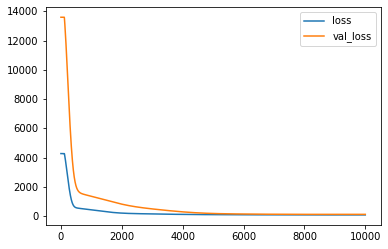

In [12]:
_ = plt.plot(history.history['loss'], label='loss')
_ = plt.plot(history.history['val_loss'], label='val_loss')
_ = plt.legend()
_ = plt.show()

There were 0 negative predictions
1-step MSE [Naive, nn model] = [198.382250792,101.88800939910706]
1-step R^2 [Naive, nn model] = [0.8413462380389802,0.9189683214344814]


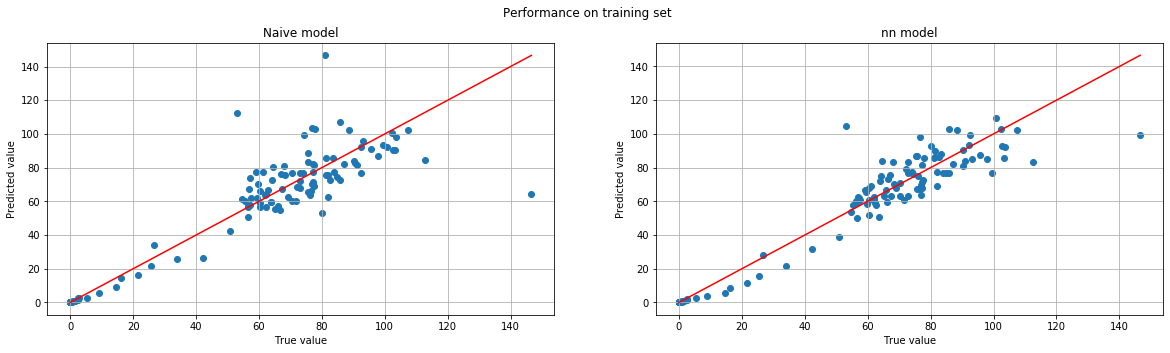

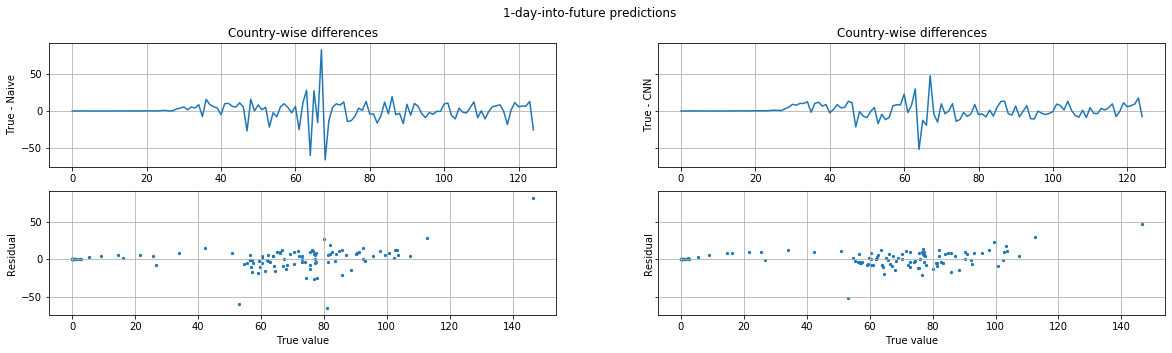

146.612 146.612 109.47652


In [13]:
y_true = y_nn_train_model.ravel()
y_predict = nn.predict(X_nn_train_model).ravel()
model_analysis(y_true, y_train_naive, y_predict, n_countries, title='nn model', suptitle='Performance on training set')
print(y_true.max(),y_train_naive.max(), y_predict.max())

There were 0 negative predictions
1-step MSE [Naive, nn model] = [170.80669257142873,140.36435150999642]
1-step R^2 [Naive, nn model] = [0.2994526992709322,0.5002592254124514]


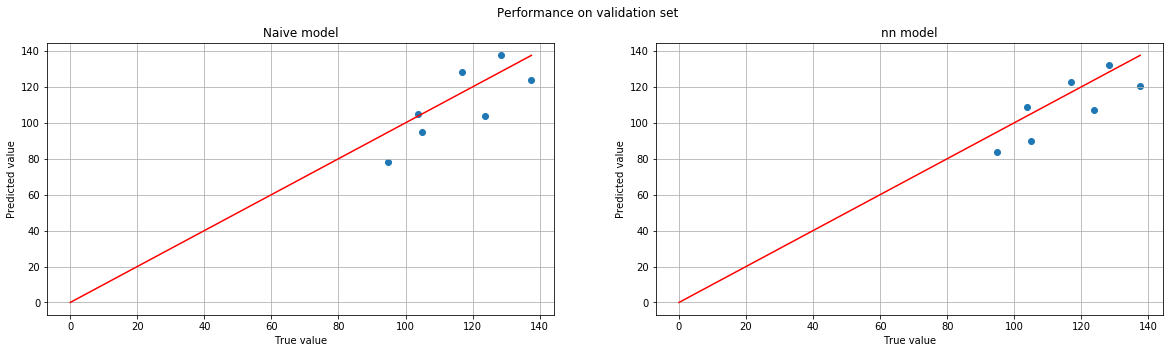

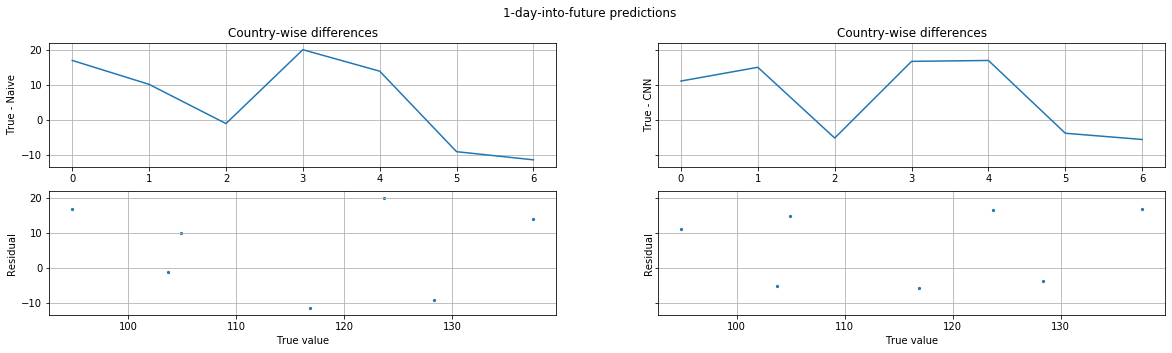

137.543 146.612 132.26942


In [14]:
y_true = y_nn_validate_model.ravel()
y_predict = nn.predict(X_nn_validate_model).ravel()
model_analysis(y_true, y_validate_naive, y_predict, n_countries, title='nn model', suptitle='Performance on validation set')
print(y_true.max(),y_train_naive.max(), y_predict.max())

# Convolutional neural network model


 The convolution will be with respect to time, specifically the time steps within frames of time of predetermined length. This brings along with it a number of important details and challenges, such as ensuring the convolution is indeed in the right dimension and that time-ordering is being respected by the training and validation process. The manner in which this is handled also has to be compatible with the keras API. The main manner in which I handle this is to 

In order to ensure that the convolution is indeed occurring a

In [15]:
X, y = create_Xy(model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries)
splits, indices = split_Xy(X, y, frame_size, n_validation_frames, n_test_frames)

scaled_splits, scaling_arrays =  normalize_Xy(splits, feature_range=(0,1.0), 
                                                                  normalization_method='minmax',
                                                                  train_test_only=False,
                                                                  feature_indices=None)
# if need to supply folds for sklearn CV regression functions.
(X_cnn_train, y_cnn_train, X_cnn_validate, y_cnn_validate, X_cnn_test, y_cnn_test) = splits
(train_indices, validate_indices, test_indices) = indices

Starting with frame ranging time_index values: 0 27
Ending with frame ranging time_index values: 132 159


In [16]:
X_cnn_train_model = np.concatenate(X_cnn_train.reshape(X_cnn_train.shape[0], X_cnn_train.shape[1], -1), axis=0)[:,:,np.newaxis]
X_cnn_validate_model = np.concatenate(X_cnn_validate.reshape(X_cnn_validate.shape[0], X_cnn_validate.shape[1], -1), axis=0)[:,:,np.newaxis]
X_cnn_test_model = np.concatenate(X_cnn_test.reshape(X_cnn_test.shape[0], X_cnn_test.shape[1], -1), axis=0)[:,:,np.newaxis]
y_cnn_train_model = y_cnn_train.ravel()
y_cnn_validate_model = y_cnn_validate.ravel()
y_cnn_test_model = y_cnn_test.ravel()

X_for_naive_slicing = np.concatenate(X.reshape(X.shape[0], X.shape[1], -1), axis=0)
n_features = X.shape[-1]
last_day_new_cases_index = np.ravel_multi_index([[frame_size-1],[new_cases_index]],(frame_size, n_features))
y_train_naive = X_for_naive_slicing[train_indices, last_day_new_cases_index].ravel()
y_validate_naive =  X_for_naive_slicing[validate_indices, last_day_new_cases_index].ravel()
y_test_naive =  X_for_naive_slicing[test_indices, last_day_new_cases_index].ravel()

In [53]:
epochs = 1000
learning_rate = 0.001
kernel = 4
N = 8
FC = 8
batch_size = X_cnn_train.shape[0]

f1, f2 = 64, 4
k1, k2 = 4, 4

cnn = Sequential()


cnn.add(Conv1D(filters=int(f1), kernel_size=int(k1),
                 padding='valid',
                 input_shape=X_cnn_train.shape[2:],
                 use_bias=False,

                )
         )

cnn.add(Conv1D(filters=int(f2), 
                 kernel_size=int(k2), 
                 padding='valid',
                 use_bias=False,

                )
         )

cnn.add(Flatten())


cnn.add(Dense(cnn.output.shape[1], 
#                 activation='relu',
#        kernel_constraint=non_neg(),


               )
         )


cnn.add(Dense(1, 
                activation='relu',
#                     kernel_constraint=non_neg(),

                   ))
cnn.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate))

In [54]:
history = cnn.fit(X_cnn_train_model, y_cnn_train_model, epochs=epochs, validation_data=(X_cnn_validate_model, y_cnn_validate_model), 
          batch_size=batch_size, verbose=0)

Train on 125 samples, validate on 7 samples
Epoch 1/1000
125/125 - 0s - loss: 2805.3523 - val_loss: 6350.3696
Epoch 2/1000
125/125 - 0s - loss: 1523.4583 - val_loss: 2712.4214
Epoch 3/1000
125/125 - 0s - loss: 701.1932 - val_loss: 529.3602
Epoch 4/1000
125/125 - 0s - loss: 1067.7330 - val_loss: 284.4736
Epoch 5/1000
125/125 - 0s - loss: 1339.0293 - val_loss: 533.6035
Epoch 6/1000
125/125 - 0s - loss: 990.5182 - val_loss: 1249.2450
Epoch 7/1000
125/125 - 0s - loss: 659.6643 - val_loss: 2274.9299
Epoch 8/1000
125/125 - 0s - loss: 595.0998 - val_loss: 3207.3997
Epoch 9/1000
125/125 - 0s - loss: 693.1058 - val_loss: 3749.0269
Epoch 10/1000
125/125 - 0s - loss: 786.8268 - val_loss: 3822.6658
Epoch 11/1000
125/125 - 0s - loss: 794.1434 - val_loss: 3489.3340
Epoch 12/1000
125/125 - 0s - loss: 713.8362 - val_loss: 2874.0188
Epoch 13/1000
125/125 - 0s - loss: 589.4933 - val_loss: 2136.0486
Epoch 14/1000
125/125 - 0s - loss: 482.9159 - val_loss: 1446.3690
Epoch 15/1000
125/125 - 0s - loss: 446.3

Epoch 126/1000
125/125 - 0s - loss: 118.5611 - val_loss: 172.4202
Epoch 127/1000
125/125 - 0s - loss: 118.4055 - val_loss: 171.3732
Epoch 128/1000
125/125 - 0s - loss: 118.2560 - val_loss: 169.2367
Epoch 129/1000
125/125 - 0s - loss: 118.1076 - val_loss: 166.6902
Epoch 130/1000
125/125 - 0s - loss: 117.9657 - val_loss: 164.7201
Epoch 131/1000
125/125 - 0s - loss: 117.8301 - val_loss: 163.7884
Epoch 132/1000
125/125 - 0s - loss: 117.6960 - val_loss: 163.5147
Epoch 133/1000
125/125 - 0s - loss: 117.5657 - val_loss: 163.0598
Epoch 134/1000
125/125 - 0s - loss: 117.4411 - val_loss: 161.8579
Epoch 135/1000
125/125 - 0s - loss: 117.3183 - val_loss: 160.0751
Epoch 136/1000
125/125 - 0s - loss: 117.1978 - val_loss: 158.3961
Epoch 137/1000
125/125 - 0s - loss: 117.0819 - val_loss: 157.3934
Epoch 138/1000
125/125 - 0s - loss: 116.9681 - val_loss: 157.0569
Epoch 139/1000
125/125 - 0s - loss: 116.8558 - val_loss: 156.8565
Epoch 140/1000
125/125 - 0s - loss: 116.7468 - val_loss: 156.2368
Epoch 141/

Epoch 251/1000
125/125 - 0s - loss: 109.1251 - val_loss: 138.6178
Epoch 252/1000
125/125 - 0s - loss: 109.0729 - val_loss: 138.5753
Epoch 253/1000
125/125 - 0s - loss: 109.0208 - val_loss: 138.5343
Epoch 254/1000
125/125 - 0s - loss: 108.9689 - val_loss: 138.4929
Epoch 255/1000
125/125 - 0s - loss: 108.9171 - val_loss: 138.4509
Epoch 256/1000
125/125 - 0s - loss: 108.8654 - val_loss: 138.4095
Epoch 257/1000
125/125 - 0s - loss: 108.8138 - val_loss: 138.3711
Epoch 258/1000
125/125 - 0s - loss: 108.7624 - val_loss: 138.3338
Epoch 259/1000
125/125 - 0s - loss: 108.7111 - val_loss: 138.2971
Epoch 260/1000
125/125 - 0s - loss: 108.6599 - val_loss: 138.2599
Epoch 261/1000
125/125 - 0s - loss: 108.6088 - val_loss: 138.2234
Epoch 262/1000
125/125 - 0s - loss: 108.5578 - val_loss: 138.1887
Epoch 263/1000
125/125 - 0s - loss: 108.5070 - val_loss: 138.1556
Epoch 264/1000
125/125 - 0s - loss: 108.4562 - val_loss: 138.1233
Epoch 265/1000
125/125 - 0s - loss: 108.4056 - val_loss: 138.0907
Epoch 266/

Epoch 376/1000
125/125 - 0s - loss: 103.4817 - val_loss: 139.7732
Epoch 377/1000
125/125 - 0s - loss: 103.4457 - val_loss: 139.8330
Epoch 378/1000
125/125 - 0s - loss: 103.4100 - val_loss: 139.8935
Epoch 379/1000
125/125 - 0s - loss: 103.3744 - val_loss: 139.9542
Epoch 380/1000
125/125 - 0s - loss: 103.3391 - val_loss: 140.0154
Epoch 381/1000
125/125 - 0s - loss: 103.3039 - val_loss: 140.0778
Epoch 382/1000
125/125 - 0s - loss: 103.2691 - val_loss: 140.1405
Epoch 383/1000
125/125 - 0s - loss: 103.2344 - val_loss: 140.2040
Epoch 384/1000
125/125 - 0s - loss: 103.1999 - val_loss: 140.2677
Epoch 385/1000
125/125 - 0s - loss: 103.1657 - val_loss: 140.3320
Epoch 386/1000
125/125 - 0s - loss: 103.1316 - val_loss: 140.3974
Epoch 387/1000
125/125 - 0s - loss: 103.0979 - val_loss: 140.4635
Epoch 388/1000
125/125 - 0s - loss: 103.0643 - val_loss: 140.5295
Epoch 389/1000
125/125 - 0s - loss: 103.0309 - val_loss: 140.5963
Epoch 390/1000
125/125 - 0s - loss: 102.9978 - val_loss: 140.6636
Epoch 391/

Epoch 501/1000
125/125 - 0s - loss: 100.7251 - val_loss: 148.8323
Epoch 502/1000
125/125 - 0s - loss: 100.7149 - val_loss: 148.8907
Epoch 503/1000
125/125 - 0s - loss: 100.7048 - val_loss: 148.9478
Epoch 504/1000
125/125 - 0s - loss: 100.6948 - val_loss: 149.0046
Epoch 505/1000
125/125 - 0s - loss: 100.6849 - val_loss: 149.0613
Epoch 506/1000
125/125 - 0s - loss: 100.6751 - val_loss: 149.1176
Epoch 507/1000
125/125 - 0s - loss: 100.6654 - val_loss: 149.1731
Epoch 508/1000
125/125 - 0s - loss: 100.6559 - val_loss: 149.2278
Epoch 509/1000
125/125 - 0s - loss: 100.6464 - val_loss: 149.2825
Epoch 510/1000
125/125 - 0s - loss: 100.6371 - val_loss: 149.3368
Epoch 511/1000
125/125 - 0s - loss: 100.6278 - val_loss: 149.3900
Epoch 512/1000
125/125 - 0s - loss: 100.6187 - val_loss: 149.4427
Epoch 513/1000
125/125 - 0s - loss: 100.6097 - val_loss: 149.4955
Epoch 514/1000
125/125 - 0s - loss: 100.6008 - val_loss: 149.5478
Epoch 515/1000
125/125 - 0s - loss: 100.5919 - val_loss: 149.5991
Epoch 516/

Epoch 626/1000
125/125 - 0s - loss: 99.9906 - val_loss: 152.9804
Epoch 627/1000
125/125 - 0s - loss: 99.9872 - val_loss: 152.9964
Epoch 628/1000
125/125 - 0s - loss: 99.9837 - val_loss: 153.0129
Epoch 629/1000
125/125 - 0s - loss: 99.9804 - val_loss: 153.0301
Epoch 630/1000
125/125 - 0s - loss: 99.9770 - val_loss: 153.0464
Epoch 631/1000
125/125 - 0s - loss: 99.9736 - val_loss: 153.0619
Epoch 632/1000
125/125 - 0s - loss: 99.9703 - val_loss: 153.0790
Epoch 633/1000
125/125 - 0s - loss: 99.9669 - val_loss: 153.0952
Epoch 634/1000
125/125 - 0s - loss: 99.9637 - val_loss: 153.1100
Epoch 635/1000
125/125 - 0s - loss: 99.9604 - val_loss: 153.1267
Epoch 636/1000
125/125 - 0s - loss: 99.9571 - val_loss: 153.1427
Epoch 637/1000
125/125 - 0s - loss: 99.9538 - val_loss: 153.1571
Epoch 638/1000
125/125 - 0s - loss: 99.9506 - val_loss: 153.1735
Epoch 639/1000
125/125 - 0s - loss: 99.9474 - val_loss: 153.1889
Epoch 640/1000
125/125 - 0s - loss: 99.9442 - val_loss: 153.2035
Epoch 641/1000
125/125 - 

Epoch 753/1000
125/125 - 0s - loss: 99.6620 - val_loss: 154.5386
Epoch 754/1000
125/125 - 0s - loss: 99.6601 - val_loss: 154.5482
Epoch 755/1000
125/125 - 0s - loss: 99.6581 - val_loss: 154.5577
Epoch 756/1000
125/125 - 0s - loss: 99.6561 - val_loss: 154.5693
Epoch 757/1000
125/125 - 0s - loss: 99.6541 - val_loss: 154.5778
Epoch 758/1000
125/125 - 0s - loss: 99.6522 - val_loss: 154.5885
Epoch 759/1000
125/125 - 0s - loss: 99.6502 - val_loss: 154.5992
Epoch 760/1000
125/125 - 0s - loss: 99.6483 - val_loss: 154.6076
Epoch 761/1000
125/125 - 0s - loss: 99.6463 - val_loss: 154.6191
Epoch 762/1000
125/125 - 0s - loss: 99.6444 - val_loss: 154.6286
Epoch 763/1000
125/125 - 0s - loss: 99.6424 - val_loss: 154.6376
Epoch 764/1000
125/125 - 0s - loss: 99.6405 - val_loss: 154.6490
Epoch 765/1000
125/125 - 0s - loss: 99.6386 - val_loss: 154.6579
Epoch 766/1000
125/125 - 0s - loss: 99.6367 - val_loss: 154.6681
Epoch 767/1000
125/125 - 0s - loss: 99.6347 - val_loss: 154.6789
Epoch 768/1000
125/125 - 

Epoch 880/1000
125/125 - 0s - loss: 99.4539 - val_loss: 155.7725
Epoch 881/1000
125/125 - 0s - loss: 99.4526 - val_loss: 155.7819
Epoch 882/1000
125/125 - 0s - loss: 99.4512 - val_loss: 155.7913
Epoch 883/1000
125/125 - 0s - loss: 99.4499 - val_loss: 155.8008
Epoch 884/1000
125/125 - 0s - loss: 99.4486 - val_loss: 155.8108
Epoch 885/1000
125/125 - 0s - loss: 99.4473 - val_loss: 155.8201
Epoch 886/1000
125/125 - 0s - loss: 99.4459 - val_loss: 155.8301
Epoch 887/1000
125/125 - 0s - loss: 99.4446 - val_loss: 155.8394
Epoch 888/1000
125/125 - 0s - loss: 99.4433 - val_loss: 155.8488
Epoch 889/1000
125/125 - 0s - loss: 99.4420 - val_loss: 155.8584
Epoch 890/1000
125/125 - 0s - loss: 99.4408 - val_loss: 155.8679
Epoch 891/1000
125/125 - 0s - loss: 99.4394 - val_loss: 155.8772
Epoch 892/1000
125/125 - 0s - loss: 99.4381 - val_loss: 155.8875
Epoch 893/1000
125/125 - 0s - loss: 99.4368 - val_loss: 155.8965
Epoch 894/1000
125/125 - 0s - loss: 99.4356 - val_loss: 155.9063
Epoch 895/1000
125/125 - 

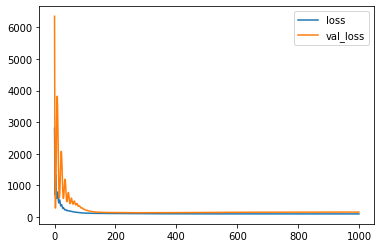

In [55]:
_ = plt.plot(history.history['loss'], label='loss')
_ = plt.plot(history.history['val_loss'], label='val_loss')
_ = plt.legend()
_ = plt.show()

There were 0 negative predictions
1-step MSE [Naive, CNN model] = [198.382250792,99.2660225518983]
1-step R^2 [Naive, CNN model] = [0.8413462380389802,0.9204912584360138]


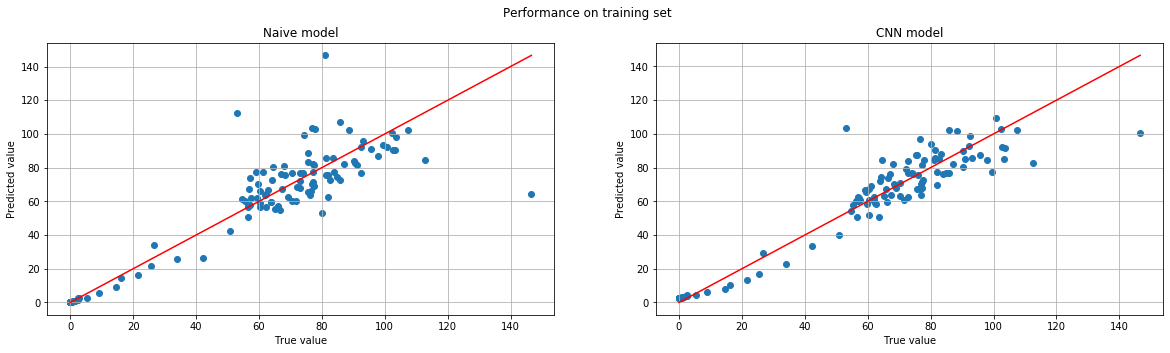

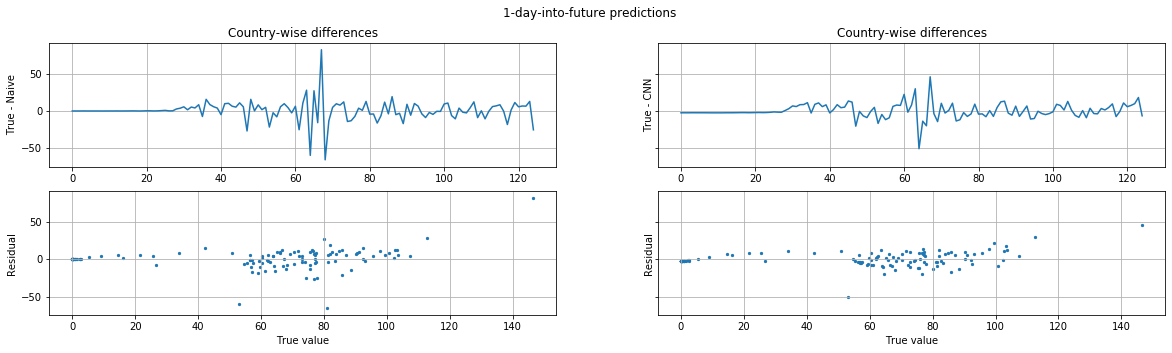

146.612 146.612 109.52159


In [51]:
y_true = y_cnn_train_model.ravel()
y_predict = cnn.predict(X_cnn_train_model).ravel()
model_analysis(y_true, y_train_naive, y_predict, n_countries, title='CNN model', suptitle='Performance on training set')
print(y_true.max(),y_train_naive.max(), y_predict.max())

There were 0 negative predictions
1-step MSE [Naive, CNN model] = [170.80669257142873,157.08513941303136]
1-step R^2 [Naive, CNN model] = [0.2994526992709322,0.5199580987623106]


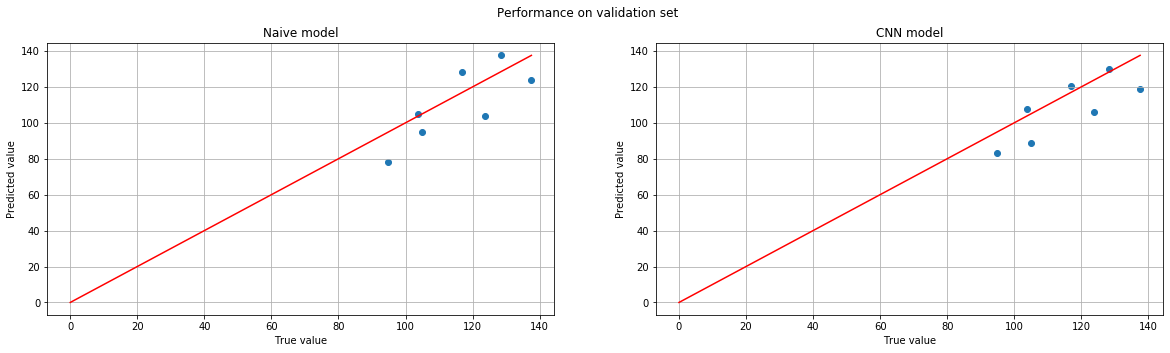

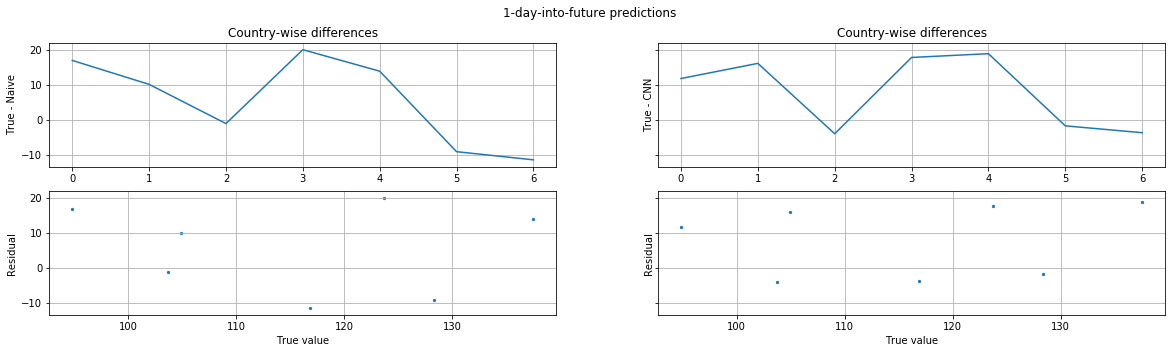

137.543 146.612 130.15561


In [52]:
y_true = y_cnn_validate_model.ravel()
y_predict = cnn.predict(X_cnn_validate_model).ravel()
model_analysis(y_true, y_validate_naive, y_predict, n_countries, title='CNN model', suptitle='Performance on validation set')
print(y_true.max(),y_train_naive.max(), y_predict.max())

In [22]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 28, 64)            256       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 28, 4)             1024      
_________________________________________________________________
flatten_1 (Flatten)          (None, 112)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 112)               12656     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 113       
Total params: 14,049
Trainable params: 14,049
Non-trainable params: 0
_________________________________________________________________


# CNN model

Time index to X relationship.

    Last frame, last day of X is time_index() - n_days_into_future
    last frame, first day is time_index() - n_days_into_future - frame_size
    first frame, first day is start_date-frame_size
    first frame, last day is start_date


# Regression

For different kinds of comparisons, I will use Ridge regression on two different datasets (technically two different subsets of the same dataset). The first contains the single feature used in the neural network modeling and the second contains most of the time-dependent features as well as their corresponding rolling features (rolling averages and std).

I do not use scaling because previous investigations not included here showed that scaling hurt the performance, using mean squared error as a metric. 

In [23]:
r_data = pd.read_csv('regression_data.csv', index_col=0)
r_data = r_data[r_data.location == 'United States']

In [24]:
r_model_data = r_data.new_cases_per_million.to_frame().copy(); new_cases_index=0
#
new_cases_index = column_search(r_model_data,'new_cases_per_million',threshold='match', return_style='iloc')[0]
n_countries = r_data.location.nunique()
target_data = r_data.new_cases_per_million
time_index = r_data.time_index.astype(int)
frame_size = 28
start_date = frame_size #+ time_index.min()
# start_date = 50
n_validation_frames = 7
n_test_frames = 1
n_days_into_future = 1
train_or_test = 'train'

In [25]:
X, y = create_Xy(r_model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries)
n_features = X.shape[-1]
last_day_new_cases_index = np.ravel_multi_index([[frame_size-1],[new_cases_index]],(frame_size, n_features))
splits, indices = split_Xy(X, y, frame_size, n_validation_frames, n_test_frames,model_type='ridge')
(train_indices, validate_indices, test_indices) = indices
X_for_naive_slicing = np.concatenate(X.reshape(X.shape[0], X.shape[1], -1), axis=0)

y_train_naive = X_for_naive_slicing[train_indices, last_day_new_cases_index]
y_validate_naive =  X_for_naive_slicing[validate_indices, last_day_new_cases_index]
y_test_naive =  X_for_naive_slicing[test_indices, last_day_new_cases_index]

flat_splits = flatten_Xy_splits(splits)
(X_regression_train, y_regression_train, X_regression_validate,
 y_regression_validate, X_regression_test, y_regression_test) = flat_splits

Starting with frame ranging time_index values: 0 27
Ending with frame ranging time_index values: 132 159


Each row is a frame of frame_size days of new_cases_per_million data for a single country. So the number of rows equals
n_countries times frame_size

This transformation (slicing off last row) is because X_regression is both training and validation
data to be sliced by the train, validation indices passed to Ridge CV. i.e. the holdout set is being held out.

In [26]:
X_regression = np.concatenate((X_regression_train, X_regression_validate),axis=0)
y_regression = np.concatenate((y_regression_train, y_regression_validate),axis=0)

scorer = make_scorer(mean_squared_error, greater_is_better=False)
ridge = RidgeCV(scoring=scorer, cv=[[train_indices, validate_indices]]) 
_ = ridge.fit(X_regression, y_regression)

There were 0 negative predictions
1-step MSE [Naive, Ridge regression model] = [198.382250792,100.32805106976801]
1-step R^2 [Naive, Ridge regression model] = [0.8413462380389802,0.9196921269889909]


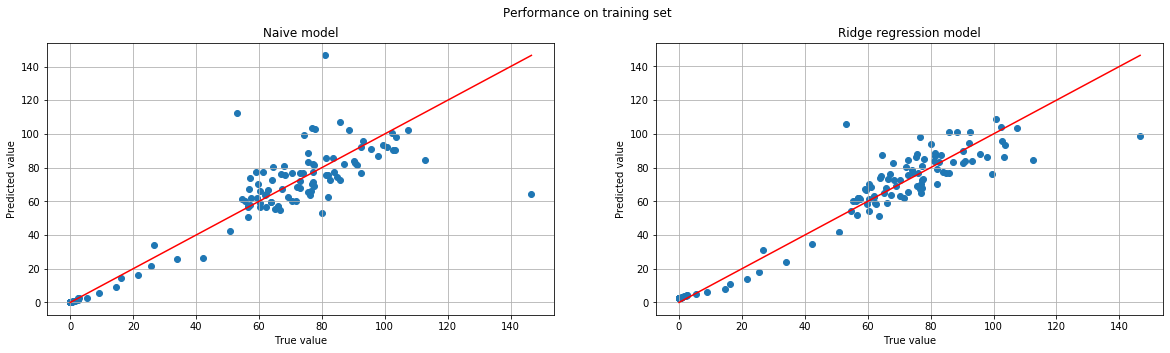

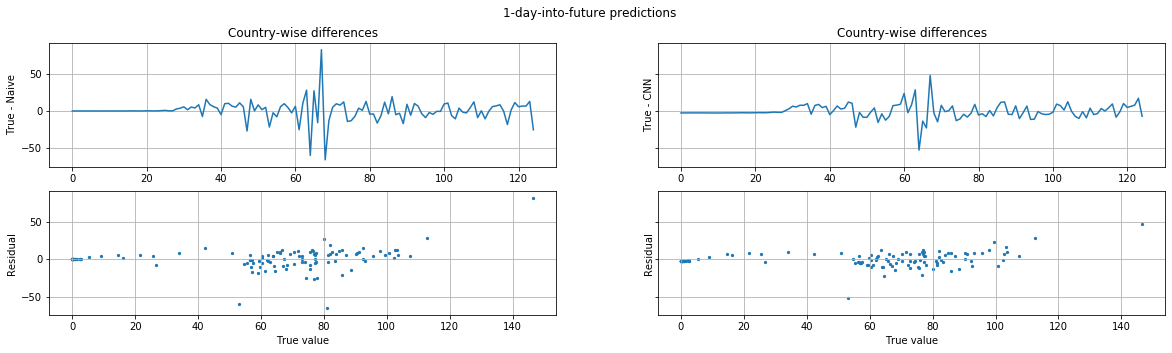

In [27]:
y_predict_train = ridge.predict(X_regression_train).ravel()

model_analysis( y_regression[train_indices].ravel(), y_train_naive, y_predict_train, 
               n_countries, title='Ridge regression model', suptitle='Performance on training set')

There were 0 negative predictions
1-step MSE [Naive, Ridge regression model] = [170.80669257142873,111.08086446025358]
1-step R^2 [Naive, Ridge regression model] = [0.2994526992709322,0.6146030489864923]


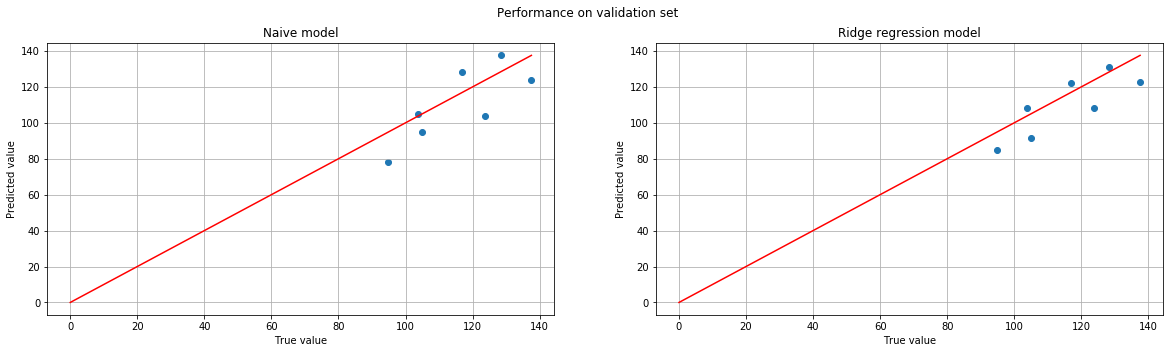

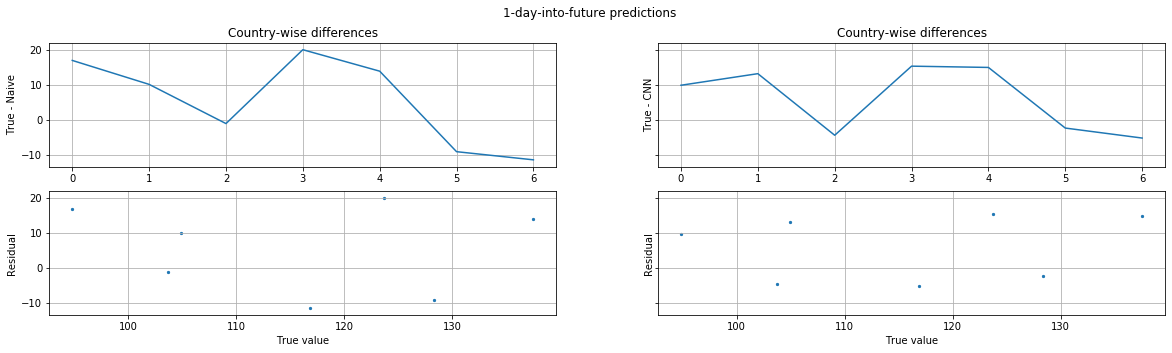

In [28]:
y_predict_validate = ridge.predict(X_regression_validate).ravel()
model_analysis( y_regression_validate.ravel(), y_validate_naive, y_predict_validate, n_countries,title='Ridge regression model', suptitle='Performance on validation set')

# Regression with all features

This is partly a sneak peak into the notebook on regression, ```COVID19_regression.ipynb``` and partly a demonstration of evidence that supports the claim that regression performs much better with more feature information, in terms of the prediction on the validation set, but actually performs much worse on the testing set.

In [35]:
r_model_data = r_data.iloc[:,2:].copy()
new_cases_index = column_search(r_model_data,'new_cases_per_million', threshold='match', return_style='iloc')[0]
n_countries = r_data.location.nunique()
target_data = r_data.new_cases_per_million
time_index = r_data.time_index.astype(int)
frame_size = 28
start_date = frame_size
n_validation_frames = 7
n_test_frames = 1
n_days_into_future = 1
train_or_test = 'train'

In [36]:
X, y = create_Xy(r_model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries)
n_features = X.shape[-1]
last_day_new_cases_index = np.ravel_multi_index([[frame_size-1],[new_cases_index]],(frame_size, n_features))
splits, indices = split_Xy(X, y, frame_size, n_validation_frames, n_test_frames,model_type='ridge')
(train_indices, validate_indices, test_indices) = indices

(X_train, y_train, X_validate,
 y_validate, X_test, y_test) = splits

Starting with frame ranging time_index values: 0 27
Ending with frame ranging time_index values: 132 159


In [37]:
X_for_naive_slicing = np.concatenate(X.reshape(X.shape[0], X.shape[1], -1), axis=0)
y_train_naive = X_for_naive_slicing[train_indices, last_day_new_cases_index]
y_validate_naive =  X_for_naive_slicing[validate_indices, last_day_new_cases_index]
y_test_naive =  X_for_naive_slicing[test_indices, last_day_new_cases_index]
# The normalization is alot easier if I split into train, validate, test but this makes other parts more annoying
scaled_splits, scaling_arrays =  normalize_Xy(splits, feature_range=(0,0.5), 
                                                                  normalization_method='minmax',
                                                                  train_test_only=False,
                                                                  feature_indices=None)

To ensure that there is no time pollution going on, look at the first and last rows of the training data to ensure
that they have the correct days.

In [38]:
flat_splits = flatten_Xy_splits(splits)
(X_regression_train, y_regression_train, X_regression_validate,
 y_regression_validate, X_regression_test, y_regression_test) = flat_splits

X_regression = np.concatenate((X_regression_train, X_regression_validate),axis=0)
y_regression = np.concatenate((y_regression_train, y_regression_validate),axis=0)

scorer = make_scorer(mean_squared_error, greater_is_better=False)
ridge = RidgeCV(scoring=scorer, cv=[[train_indices, validate_indices]]) 
_ = ridge.fit(X_regression, y_regression)

In [39]:
X_for_naive_slicing = np.concatenate(X.reshape(X.shape[0], X.shape[1], -1), axis=0)
n_features = X.shape[-1]
new_cases_indices = np.ravel_multi_index([list(range(frame_size)),[new_cases_index]],(frame_size, n_features))
new_cases_indices

array([  2,  20,  38,  56,  74,  92, 110, 128, 146, 164, 182, 200, 218,
       236, 254, 272, 290, 308, 326, 344, 362, 380, 398, 416, 434, 452,
       470, 488], dtype=int64)

In [40]:
# The first frame should have time values from 0 to 27.
r_model_data.new_cases_per_million.iloc[:28].values-X_regression_train[0, new_cases_indices]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [41]:
# The last row or last frame, should have values from time_index.max()-1-n_test_frames-n_validation_frames-frame_size to time_index.max()-1-n_test_frames-n_validation_frames
(r_model_data.new_cases_per_million.iloc[-28-n_test_frames-n_validation_frames-1:-n_test_frames-n_validation_frames-1].values
 -X_regression_train[-1, new_cases_indices])

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

There were 8 negative predictions
1-step MSE [Naive, Ridge] = [198.382250792,1.652614844797649]
1-step R^2 [Naive, Ridge] = [0.8413462380389802,0.9986757489502933]


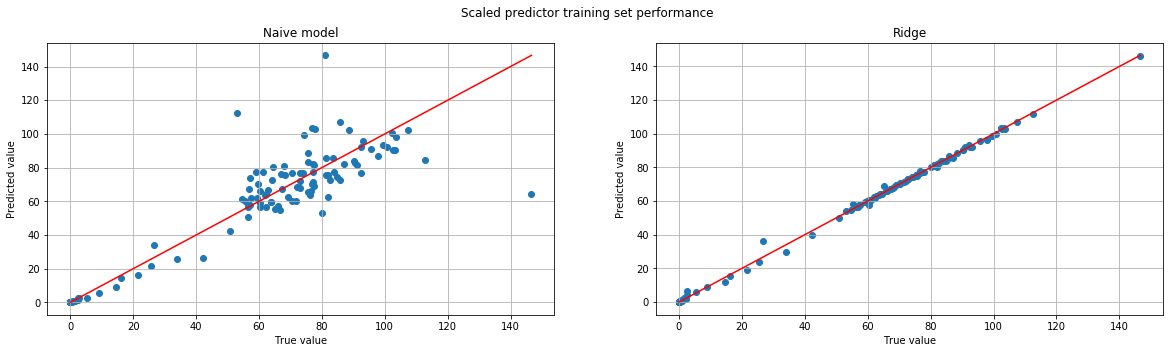

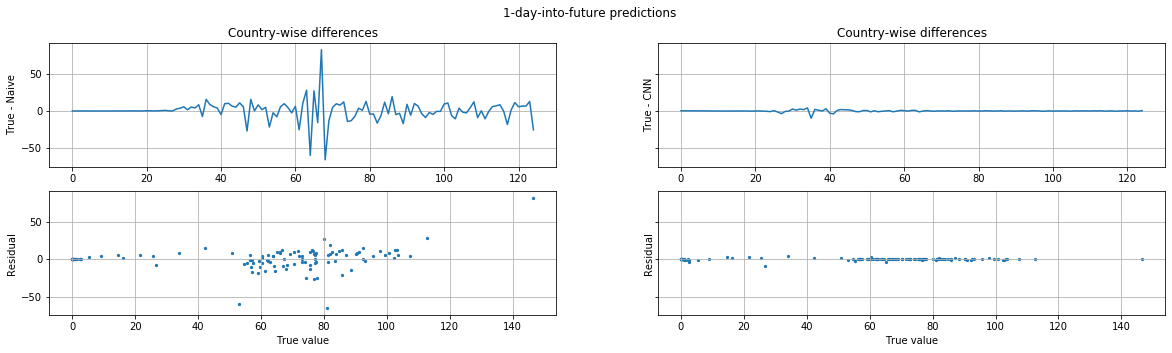

In [42]:
y_predict_train = ridge.predict(X_regression_train).ravel()
model_analysis(y_regression_train, y_train_naive, y_predict_train, n_countries, title='Ridge', suptitle='Scaled predictor training set performance')

There were 0 negative predictions
1-step MSE [Naive, Ridge] = [170.80669257142873,0.05885456973119241]
1-step R^2 [Naive, Ridge] = [0.2994526992709322,0.9997077742130718]


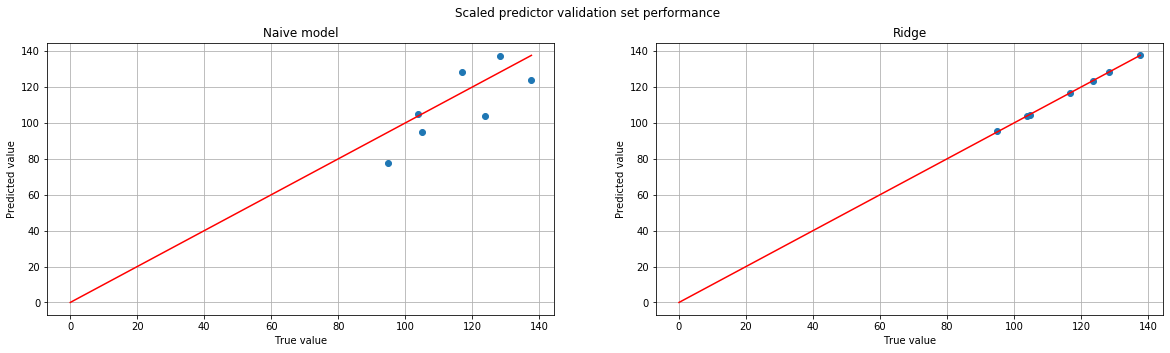

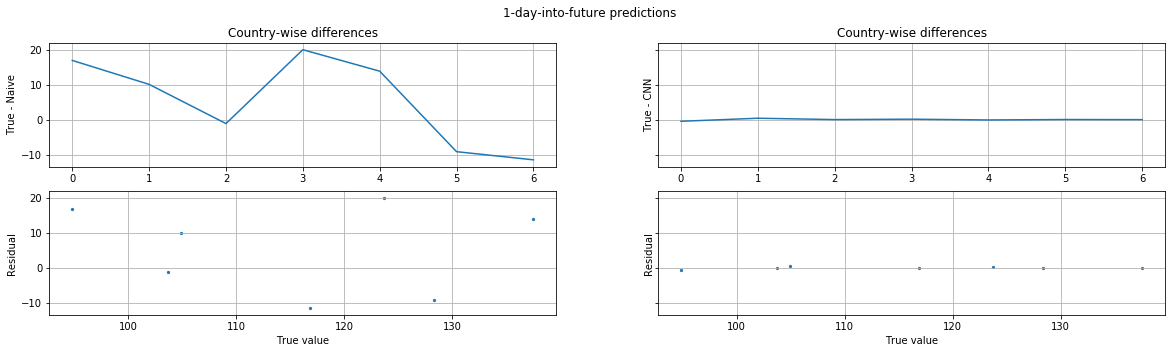

In [43]:
y_predict_validate = ridge.predict(X_regression_validate).ravel()
model_analysis(y_regression_validate, y_validate_naive, y_predict_validate, n_countries, title='Ridge', suptitle='Scaled predictor validation set performance')

# Final predictions for comparison

In [44]:
y_naive = y_test_naive
y_true = y_test
y_predict_r = ridge.predict(X_regression_test)
y_predict_c = cnn.predict(X_cnn_test_model)
y_predict_n = nn.predict(X_nn_test_model)

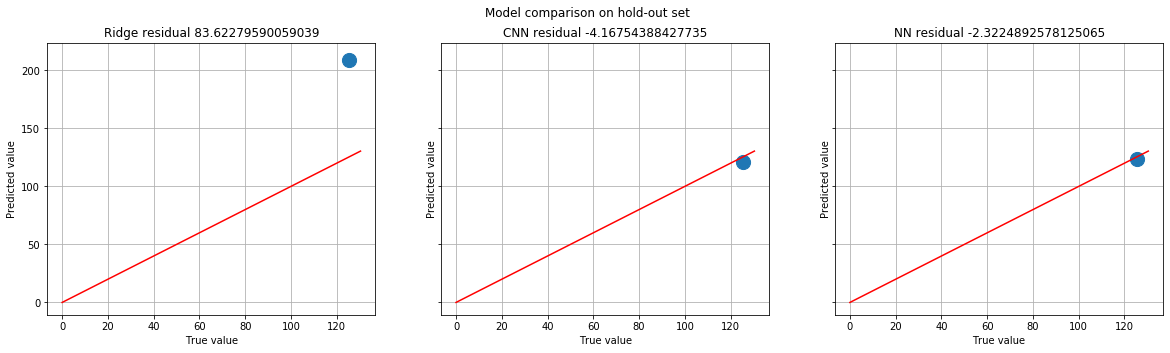

In [47]:
s = 200
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5),sharey=True)

ymax = np.max([y_true.max(), y_predict.max()])
ax1.plot([0, ymax], [0, ymax],color='r')
ax1.scatter(y_true, y_predict_r, s=s)
ax2.plot([0, ymax], [0, ymax],color='r')
ax2.scatter(y_true, y_predict_c, s=s)
ax3.plot([0, ymax], [0, ymax],color='r')
ax3.scatter(y_true, y_predict_n, s=s)

ax1.set_xlabel('True value')
ax1.set_ylabel('Predicted value')
ax1.set_title('Ridge residual '+str(y_predict_r.ravel()[0]-y_true.ravel()[0]))

ax2.set_xlabel('True value')
ax2.set_ylabel('Predicted value')
ax2.set_title('CNN residual '+str(y_predict_c.ravel()[0]-y_true.ravel()[0]))

ax3.set_xlabel('True value')
ax3.set_ylabel('Predicted value')
ax3.set_title('NN residual '+str(y_predict_n.ravel()[0]-y_true.ravel()[0]))

ax1.grid(True)
ax2.grid(True)
ax3.grid(True)
plt.suptitle('Model comparison on hold-out set')
plt.show()